# Предподготовка, очистка, фильтрация данных
# Извлечение полезной информации    


### В этом ноутбуке содержатся тренировочные материалы, решение задач с онлайн-курсов по обработке и анализу данных в Python

**Структура ноутбука**:  
1. Простая фильтрация и группировка данных по условию. Объединение таблиц  
3. Выгрузка из вложенных файлов. Объединение выгрузок
4. Фильтрация данных с помощью функции query и преобразование с apply и lambda-функциями  
5. Начальная обработка и извлечение полезной информации из датасета  
6. Визуализация для предобработки (гистограмма и график корреляции)    
7. Создание новых признаков (ручное создание признаков, полиномиальные признаки, dummy-переменные, работа с датой/временем)   
8. Поиск выбросов (поиск и удаление по порогу, поиск по отклонению (z-score), IQR, поиск по распределению, DBSCAN)    
9. Работа с датами

In [2]:
# Загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os, re, warnings, operator
from pprint import pprint
from datetime import datetime, timedelta
from scipy.stats import norm
from statsmodels.stats import weightstats   # weightstats.CompareMeans.ztest_ind()   weightstats.ttest_ind()
from math import radians, sin, cos, asin, sqrt
from itertools import combinations

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, PolynomialFeatures, OneHotEncoder
from sklearn.cluster import DBSCAN

## 1. Простая фильтрация и группировка данных по условию. Объединение таблиц

### ЗАДАНИЕ 1.  
### Ответить на вопросы, применив различные способы фильтрации и группировки данных
В задании используется датасет с информацией о футболистах

In [3]:
# Загрузим данные и посмотрим на них детальнее
football = pd.read_csv('data_sf.csv')
display(football.head())

,Unnamed: 0,Name,Age,Nationality,Club,Value,Wage,Position,Crossing,Finishing,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,0,L. Messi,31,Argentina,FC Barcelona,110500000,565000,RF,84,95,...,75,96,33,28,26,6,11,15,14,8
1,1,Cristiano Ronaldo,33,Portugal,Juventus,77000000,405000,ST,84,94,...,85,95,28,31,23,7,11,15,14,11
2,2,Neymar Jr,26,Brazil,Paris Saint-Germain,118500000,290000,LW,79,87,...,81,94,27,24,33,9,9,15,15,11
3,3,De Gea,27,Spain,Manchester United,72000000,260000,GK,17,13,...,40,68,15,21,13,90,85,87,88,94
4,4,K. De Bruyne,27,Belgium,Manchester City,102000000,355000,RCM,93,82,...,79,88,68,58,51,15,13,5,10,13


In [6]:
# Посмотрим на структуру датасета
display(football.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12897 entries, 0 to 12896
Data columns (total 42 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Unnamed: 0       12897 non-null  int64 
 1   Name             12897 non-null  object
 2   Age              12897 non-null  int64 
 3   Nationality      12897 non-null  object
 4   Club             12897 non-null  object
 5   Value            12897 non-null  int64 
 6   Wage             12897 non-null  int64 
 7   Position         12897 non-null  object
 8   Crossing         12897 non-null  int64 
 9   Finishing        12897 non-null  int64 
 10  HeadingAccuracy  12897 non-null  int64 
 11  ShortPassing     12897 non-null  int64 
 12  Volleys          12897 non-null  int64 
 13  Dribbling        12897 non-null  int64 
 14  Curve            12897 non-null  int64 
 15  FKAccuracy       12897 non-null  int64 
 16  LongPassing      12897 non-null  int64 
 17  BallControl      12897 non-null

None

In [9]:
# Выведем статистическую информацию
display(football.describe())
display(football.describe(include = 'object'))

,Unnamed: 0,Age,Value,Wage,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
count,12897.000000,12897.000000,1.289700e+04,12897.000000,12897.000000,12897.000000,12897.000000,12897.000000,12897.000000,12897.000000,...,12897.000000,12897.000000,12897.000000,12897.000000,12897.000000,12897.000000,12897.000000,12897.000000,12897.000000,12897.000000
mean,6605.040862,24.795379,2.112449e+06,7517.562224,47.076374,42.876328,50.202528,56.026983,40.295030,52.461735,...,46.459874,55.942932,45.655811,46.186710,44.386679,17.218345,16.962317,16.797938,16.950221,17.315965
std,3782.545526,4.872212,6.498424e+06,23061.985387,18.043470,19.096935,17.281593,14.740436,17.080687,18.871643,...,15.479313,11.280631,19.456346,21.172586,20.726546,18.085618,17.349624,16.971411,17.369297,18.335817
min,0.000000,16.000000,0.000000e+00,1000.000000,5.000000,2.000000,4.000000,7.000000,4.000000,4.000000,...,5.000000,12.000000,3.000000,2.000000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,3357.000000,21.000000,2.500000e+05,1000.000000,35.000000,28.000000,43.000000,50.000000,28.000000,45.000000,...,37.000000,49.000000,29.000000,25.000000,23.000000,8.000000,8.000000,8.000000,8.000000,8.000000
50%,6622.000000,24.000000,5.000000e+05,2000.000000,51.000000,45.000000,54.000000,60.000000,41.000000,58.000000,...,47.000000,56.000000,51.000000,54.000000,51.000000,11.000000,11.000000,11.000000,11.000000,11.000000
75%,9876.000000,28.000000,8.500000e+05,4000.000000,61.000000,59.000000,62.000000,65.000000,53.000000,65.000000,...,58.000000,63.000000,62.000000,64.000000,62.000000,14.000000,14.000000,14.000000,14.000000,14.000000
max,13125.000000,45.000000,1.185000e+08,565000.000000,93.000000,95.000000,94.000000,93.000000,90.000000,97.000000,...,91.000000,96.000000,93.000000,93.000000,91.000000,90.000000,92.000000,91.000000,90.000000,94.000000


,Name,Nationality,Club,Position
count,12897,12897,12897,12897
unique,12326,156,650,27
top,J. Rodríguez,England,V-Varen Nagasaki,GK
freq,9,1368,30,1641


Итак, датафрейм football представляет собой таблицу с информацией о футболистах: имена и фамилии игроков, национальность, возраст, принадлежность к клубу, заработанная плата и различные спортивные показатели. Всего в наборе данных 42 колонки, в каждой из которых 12897 непустых значений. Пропуски в данных отсутствуют. В таблице 4 признака с типом данных object, остальные признаки имеют тип int. 

### Ответим на ряд вопросов, применив различные способы фильтрации и группировки данных

In [25]:
# Какова средняя скорость футболистов, зарплата которых выше среднего? Ответ округлите до сотых
# round(football.query('Wage > Wage.mean()').SprintSpeed.mean(), 2)
display(round(football[football['Wage'] > football['Wage'].mean()]['SprintSpeed'].mean(), 2))

# Какую позицию занимает футболист с самой высокой зарплатой?
# football[football.Wage.isin([football.Wage.max()])].Position
# football.query('Wage == Wage.max()').Position
display(football[football['Wage'] == football['Wage'].max()]['Position'].iloc[0])

# Сколько пенальти забили бразильские футболисты за период, данные о котором представлены в датасете?
display(football[football['Nationality'] == 'Brazil']['Penalties'].sum())

# Укажите средний возраст игроков, у которых точность удара головой > 50
display(round(football[football['HeadingAccuracy'] > 50]['Age'].mean(), 2))

# Укажите возраст самого молодого игрока, у которого хладнокровие и реакция превышают 90% от максимального значения, 
# представленного в датасете
display(football[(football['Composure'] > football['Composure'].max() * 0.9) & (football['Reactions'] > football['Reactions'].max() * 0.9)]['Age'].min())

# Определите, насколько средняя реакция самых взрослых игроков больше средней реакции самых молодых игроков
# round(football.query('Age == Age.max()').Reactions.mean() - football.query('Age == Age.min()').Reactions.mean(),2)
display(round((football[football['Age'] == football['Age'].max()]['Reactions'].mean()) - (football[football['Age'] == football['Age'].min()]['Reactions'].mean()), 2))

67.57

'RF'

22789

25.59

24

22.64

In [26]:
# Из какой страны происходит больше всего игроков, чья стоимость превышает среднее значение?
display(football[football['Value'] > football['Value'].mean()]['Nationality'].value_counts().index[0])

# Определите, во сколько раз средняя зарплата голкипера с максимальным значением показателя "Рефлексы" 
# выше средней зарплаты голкипера с максимальным значением показателя "Владение мячом"
# round(football.query('(Position == "GK") & (GKReflexes == GKReflexes.max())').Wage.mean() / football.query('(Position == "GK") & (GKHandling == GKHandling.max())').Wage.mean(), 2)
display(round(football[(football['Position'] == 'GK') & (football['GKReflexes'] == football['GKReflexes'].max())]['Wage'].mean() / football[(football['Position'] == 'GK') & (football['GKHandling'] == football['GKHandling'].max())]['Wage'].mean(), 2))

# Определите, во сколько раз средняя сила удара самых агрессивных игроков выше средней силы удара игроков с минимальной агрессией
# round(football.query('Aggression == Aggression.max()').ShotPower.mean() / football.query('Aggression == Aggression.min()').ShotPower.mean(), 2)
display(round(football[football['Aggression'] == football['Aggression'].max()]['ShotPower'].mean() / football[football['Aggression'] == football['Aggression'].min()]['ShotPower'].mean(), 2))

# Данные об игроках каких позиций занимают более 10% датасета?
# football.groupby('Position').Name.count()[football.groupby('Position').Name.count() > len(football.Position) * 0.1].index.tolist()
pos_2 = football['Position'].value_counts(normalize = True)
display(pos_2[pos_2 > 0.1].index.tolist())

# Данные об игроках каких позиций занимают менее 1% датасета?
# football.groupby('Position').Name.count()[football.groupby('Position').Name.count() < football.Position.shape[0] * 0.01]
display(football.Position.value_counts(normalize = True)[football.Position.value_counts(normalize = True) < 0.01].index.tolist())

# В каких пределах находятся худшие 20% показателей точности ударов ногой?
display(football['FKAccuracy'].value_counts(bins = 5).index.min())

'Spain'

2.77

2.08

['GK', 'ST', 'CB']

['LS', 'RS', 'RWB', 'LWB', 'CF', 'LF', 'LAM', 'RF', 'RAM']

Interval(2.908, 21.2, closed='right')

In [31]:
# У какого процента испанских футболистов зарплата находится в пределах 25% минимума 
# от наблюдаемого уровня зарплат среди испанских игроков?
wage_proportion = football[football['Nationality'] == 'Spain']['Wage'].value_counts(bins = 4, normalize = True)
# round(wage_proportion[wage_proportion.index.min()], 2)
display(round(wage_proportion[sorted(wage_proportion.index)[0]], 2))

# Укажите количество национальностей, к которым относятся футболисты, выступающие за клуб "Manchester United"
# len(football[football.Club.isin(['Manchester United'])].Nationality.unique())
# len(football[football.Club == 'Manchester United'].Nationality.value_counts())
display(football[football['Club'] == 'Manchester United']['Nationality'].nunique())

# Определите двух футболистов из Бразилии, выступающих за клуб 'Juventus'
display(football[(football['Nationality'] == 'Brazil') & (football['Club'] == 'Juventus')][['Name']])

# Укажите, какие два клуба насчитывают наибольшее количество футболистов возрастом старше 35 лет
display(football[football.Age > 35].Club.value_counts().sort_values(ascending = False)[:2])   # .sort_values()[-2:]) 
display(football[football.Age > 35].groupby('Club').Name.count().sort_values(ascending = False).index.tolist()[:2])

# Решение с помощью isin()
small_data = football[football['Age'] > 35]['Club'].value_counts()
display(small_data[small_data.isin([small_data.max()])])     # small_data.index[:2]

0.97

13

,Name
64,Alex Sandro
65,Douglas Costa


Hokkaido Consadole Sapporo    4
Club Atlético Huracán         4
Name: Club, dtype: int64

['Club Atlético Huracán', 'Hokkaido Consadole Sapporo']

Hokkaido Consadole Sapporo    4
Club Atlético Huracán         4
Name: Club, dtype: int64

In [4]:
# Разбейте всех футболистов родом из Аргентины на 4 равные группы по возрасту. 
# Сколько футболистов из Аргентины в возрасте от 34,75 до 41 года?
argentina_players_age = football[football['Nationality'] == 'Argentina']['Age'].value_counts(bins = 4)
display(argentina_players_age[argentina_players_age.index.left >= 34.75])

# Сколько процентов футболистов из Испании имеют возраст 21 год? 
# Введите с точностью до 2 знаков после запятой без указания знака % (например, 12.35)
# round(football[(football.Age == 21) & (football.Nationality == 'Spain')].Name.nunique() / len(football[football.Nationality == 'Spain']),2)
display(round(football[football['Nationality'] == 'Spain']['Age'].value_counts(normalize = True)[21], 2))

# Определите позиции, по которым общая сумма зарплат игроков превышает 5 млн евро в год
display(football.groupby(['Position'])['Wage'].sum()[football.groupby(['Position'])['Wage'].sum() > 5000000].index.tolist())
print(*football.groupby(['Position'])['Wage'].sum()[football.groupby(['Position'])['Wage'].sum() > 5000000].index.tolist(), sep = ' ')
display(football.groupby(['Position'])['Wage'].sum()[football.groupby(['Position'])['Wage'].sum() > 5000000])

# Посчитайте среднюю зарплату и цену игроков разных позиций. Представители какой позиции имеют самую высокую среднюю ценность? 
# Какова средняя зарплата футболистов на данной позиции?
# football.groupby('Position', as_index = False).agg(mean_wage = ('Wage', 'mean'), mean_value = ('Value', 'mean'))
display(football.groupby('Position', as_index = False)[['Wage', 'Value']].mean().head(3))
display(football.groupby('Position', as_index = False)[['Wage', 'Value']].mean().sort_values(by = 'Value', ascending = False).iloc[[0]])

# football.groupby(['Position'])['Wage'].mean().loc['LF']
# football.groupby(football['Position'] == 'LF')['Wage'].mean()[1]
display(football[football.Position == 'LF'].Wage.mean())

(34.75, 41.0]    49
Name: Age, dtype: int64

0.12

['CAM', 'CB', 'CM', 'GK', 'LB', 'LM', 'RB', 'RM', 'ST']

CAM CB CM GK LB LM RB RM ST


Position
CAM     5500000
CB      7476000
CM      6194000
GK      8784000
LB      6096000
LM      5440000
RB      5034000
RM      5098000
ST     11873000
Name: Wage, dtype: int64

,Position,Wage,Value
0,CAM,8688.783570,2.963199e+06
1,CB,5328.581611,1.321251e+06
2,CDM,7121.562952,1.658900e+06


,Position,Wage,Value
11,LF,75125.0,27362500.0


75125.0

In [159]:
# Посчитайте среднюю и медианную зарплату футболистов из разных клубов. 
# В скольких клубах средняя и медианная зарплаты совпадают?
football_2 = football.groupby('Club', as_index = False) \
        .agg(mean_wage = ('Wage','mean'), median_wage = ('Wage','median'))
display(football_2.head(3))

# len(football_2[football_2.mean_wage == football_2.median_wage])
# football_2[football_2.mean_wage == football_2.median_wage].Club.nunique()
display(football_2[football_2.mean_wage == football_2.median_wage].Club.count())

# ДРУГОЙ ВАРИАНТ ГРУППИРОВКИ
football_new = football.groupby('Club').Wage.agg(func = ['mean', 'median']).reset_index() \
                .rename(columns = {'mean' : 'mean_wage', 'median': 'median_wage'})
display(football_new.head(3))
display(len(football_new[football_new.mean_wage == football_new.median_wage]) )


# Продолжаем работать с клубами, в которых средняя зарплата совпадает с медианной. 
# Каков максимальный размер средней зарплаты в этой группе клубов?
equals = football_2[football_2.mean_wage == football_2.median_wage]
display(equals.head(3))
display(equals['mean_wage'].max())

# Как называется клуб, где игроки получают такую зарплату?
# equals.sort_values('mean_wage', ascending = False)[:1]
# equals[equals['mean_wage'] == equals['mean_wage'].max()]
display(equals[equals.mean_wage.isin([equals.mean_wage.max()])])

,Club,mean_wage,median_wage
0,SSV Jahn Regensburg,3750.000000,3500.0
1,1. FC Heidenheim 1846,3800.000000,3000.0
2,1. FC Kaiserslautern,1434.782609,1000.0


52

,Club,mean_wage,median_wage
0,SSV Jahn Regensburg,3750.000000,3500.0
1,1. FC Heidenheim 1846,3800.000000,3000.0
2,1. FC Kaiserslautern,1434.782609,1000.0


52

,Club,mean_wage,median_wage
4,1. FC Magdeburg,4000.0,4000.0
12,AEK Athens,1000.0,1000.0
15,AJ Auxerre,2000.0,2000.0


13000.0

,Club,mean_wage,median_wage
168,Cruzeiro,13000.0,13000.0


In [6]:
# Посчитайте сумму зарплат футболистов клуба "Chelsea"
# football.groupby('Club')['Wage'].sum()['Chelsea']
# football.groupby(football['Club'] == "Chelsea")['Wage'].sum()[1]
display(football[football.Club == 'Chelsea'].Wage.sum())

# Определите минимальную и максимальную зарплату футболиста национальности Аргентина в возрасте 20 лет
# football.query('(Nationality == "Argentina") & (Age == 20)').agg(min_wage = ('Wage', 'min'), max_wage = ('Wage', 'max'))
display(football[(football.Nationality == 'Argentina') & (football.Age == 20)].Wage.agg(['min', 'max']).to_frame())

# Определите минимальную и максимальную зарплату футболиста национальности Аргентина в возрасте 30 лет
# football.query('(Nationality == "Argentina") & (Age == 30)').Wage.agg(['min', 'max']).to_frame()
display(football[(football.Nationality == 'Argentina') & (football.Age == 30)].agg(min_wage = ('Wage', 'min'), max_wage = ('Wage', 'max')))

# Определите максимальную силу и баланс среди игроков клуба "FC Barcelona" из Аргентины
# football.query("(Nationality == 'Argentina') & (Club == 'FC Barcelona')")[['Strength', 'Balance']].max()
# football.groupby((football['Club'] == "FC Barcelona") & (football['Nationality'] == "Argentina"))[['Strength', 'Balance']].max().loc[1]
display(football[(football['Club'] == "FC Barcelona") & (football['Nationality'] == "Argentina")][['Strength', 'Balance']].max())

2035000

,Wage
min,1000
max,54000


,Wage
min_wage,1000
max_wage,300000


Strength    59
Balance     95
Name: True, dtype: int64

In [283]:
# Создайте сводную таблицу, содержащую сведения о количестве игроков, занимающих разные позиции в каждом клубе. 
# Отсутствующие значения замените нулями. Каково среднее количество вратарей (GK) по всем клубам?

# Сводная таблица с мультииндексами:
pivot_1 = football.pivot_table(index = ['Club'], columns = ['Position'], values = ['Name'], aggfunc = 'count', fill_value = 0)
display(pivot_1.head(3))
display(pivot_1.index[:3])
display(pivot_1.columns[:3])
print(f'Среднее количество вратарей (GK) по всем клубам: {round(pivot_1["Name", "GK"].mean(), 2)}')


# Сводная таблица с привычными индексами:
pivot_2 = football.pivot_table(index = 'Club', columns = 'Position', values = 'Name', aggfunc = 'count', fill_value = 0)
display(pivot_2.head(3))
display(pivot_2.index[:3])
display(pivot_2.columns[:3])
print(f'Среднее количество вратарей (GK) по всем клубам: {round(pivot_2["GK"].mean(), 2)}')

# Используя таблицу, созданную на предыдущем шаге, определите, сколько клубов не содержат данных о центральных полузащитниках 
# (CM)
# pivot_1['Name', 'CM'].value_counts().loc[0]
# pivot_1[pivot_1['Name']['CM'] == 0].reset_index().Club.nunique()
# pivot_1[pivot_1['Name']['CM'] == 0]['Name', 'CM'].count()
display(len(pivot_1[pivot_1['Name', 'CM'] == 0]))
display(len(pivot_2[pivot_2['CM'] == 0]))


# С помощью сводной таблицы посчитайте, сколько получают русские футболисты, играющие за ФК "AS Monaco"
pivot_3 = football.loc[football['Nationality'].isin(['Russia'])].pivot_table(index = 'Club', columns = 'Nationality', 
                                                                             values = 'Wage', aggfunc = 'sum') 
display(pivot_3.head(3))
display(pivot_3.loc["AS Monaco"])

# ДРУГОЙ ВАРИАНТ РЕШЕНИЯ
pivot_4 = football.pivot_table(index = 'Nationality', columns = 'Club', values = 'Wage', 
                               aggfunc = 'sum', fill_value = 0).reset_index()
pivot_4[pivot_4.Nationality == 'Russia']["AS Monaco"]

Name                                 ...                 \
Position               CAM CB CDM CF CM GK LAM LB LCB LCM  ... RB RCB RCM RDM   
Club                                                       ...                  
 SSV Jahn Regensburg     0  5   1  0  2  3   0  2   0   0  ...  2   1   0   1   
1. FC Heidenheim 1846    1  3   0  0  1  2   0  2   1   0  ...  2   1   0   0   
1. FC Kaiserslautern     0  3   3  0  0  3   0  2   1   0  ...  2   0   0   1   

                                          
Position              RF RM RS RW RWB ST  
Club                                      
 SSV Jahn Regensburg   0  0  0  0   0  3  
1. FC Heidenheim 1846  0  3  0  0   0  2  
1. FC Kaiserslautern   0  2  1  0   0  1  

[3 rows x 27 columns]

Index([' SSV Jahn Regensburg', '1. FC Heidenheim 1846',
       '1. FC Kaiserslautern'],
      dtype='object', name='Club')

MultiIndex([('Name', 'CAM'),
            ('Name',  'CB'),
            ('Name', 'CDM')],
           names=[None, 'Position'])

Среднее количество вратарей (GK) по всем клубам: 2.52


Position,CAM,CB,CDM,CF,CM,GK,LAM,LB,LCB,LCM,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
Club,,,,,,,,,,,,,,,,,,,,,
SSV Jahn Regensburg,0,5,1,0,2,3,0,2,0,0,...,2,1,0,1,0,0,0,0,0,3
1. FC Heidenheim 1846,1,3,0,0,1,2,0,2,1,0,...,2,1,0,0,0,3,0,0,0,2
1. FC Kaiserslautern,0,3,3,0,0,3,0,2,1,0,...,2,0,0,1,0,2,1,0,0,1


Index([' SSV Jahn Regensburg', '1. FC Heidenheim 1846',
       '1. FC Kaiserslautern'],
      dtype='object', name='Club')

Index(['CAM', 'CB', 'CDM'], dtype='object', name='Position')

Среднее количество вратарей (GK) по всем клубам: 2.52


136

136

Nationality,Russia
Club,
AS Monaco,61000
Cracovia,1000
Dalkurd FF,1000


Nationality
Russia    61000
Name: AS Monaco, dtype: int64

122    61000
Name: AS Monaco, dtype: int64

In [20]:
# Создайте сводную таблицу, содержащую сведения о средней скорости футболистов, 
# занимающих разные позиции в разных футбольных клубах
pivot_5 = football.pivot_table(index = 'Club', columns = 'Position', values = 'SprintSpeed', aggfunc = 'mean', fill_value = 0)
display(pivot_5.head(3))

# Основываясь на данных таблицы, выделите три позиции, представители которых обладают самой высокой скоростью
# pivot_5.loc[:].max().sort_values(ascending = False).index.tolist()[:3]
display(pivot_5.max().sort_values(ascending = False)[:3])

# Используя таблицу, созданную на предыдущем шаге, выделите названия трёх клубов, в которых центральные форварды (ST) 
# обладают наибольшей средней скоростью
# pivot_5['ST'].sort_values(ascending = False).index.tolist()[:3]
# pivot_5.sort_values('ST').index.tolist()[-3:]
display(pivot_5.reset_index().sort_values(by = 'ST', ascending = False)[['Club', 'ST']][:3])

Position,CAM,CB,CDM,CF,CM,GK,LAM,LB,LCB,LCM,...,RB,RCB,RCM,RDM,RF,RM,RS,RW,RWB,ST
Club,,,,,,,,,,,,,,,,,,,,,
SSV Jahn Regensburg,0.0,46.600000,82.000000,0.0,61.0,33.000000,0,76.0,0.0,0.0,...,68.5,57.0,0,65.0,0,0.000000,0,0.0,0.0,61.666667
1. FC Heidenheim 1846,68.0,61.333333,0.000000,0.0,68.0,41.000000,0,60.0,55.0,0.0,...,80.5,59.0,0,0.0,0,78.333333,0,0.0,0.0,69.000000
1. FC Kaiserslautern,0.0,59.000000,65.666667,0.0,0.0,42.666667,0,68.0,45.0,0.0,...,71.5,0.0,0,55.0,0,82.500000,69,0.0,0.0,79.000000


Position
LM    94.0
RS    94.0
RM    94.0
dtype: float64

Position,Club,ST
621,Vitória,91.0
571,Sydney FC,88.0
111,CD Lugo,87.0


### ЗАДАНИЕ 2.   
### Ответить на вопросы, применив различные способы объединения таблиц  
В задании используется датасет с логами рекомендательной системы фильмов. Основой данных будут две таблицы. 

**Таблица ratings —  данные о выставленных оценках фильмов. Содержит признаки:**  
- **userId** — идентификатор пользователя, который поставил оценку фильму
- **movieId** — идентификатор фильма
- **rating** — выставленная оценка
- **timestamp** — время (в формате unix time), когда была выставлена оценка

**Таблица movies — расшифровка идентификаторов фильмов. Содержит признаки:**  
- **movieId** — идентификатор фильма
- **title** — название фильма
- **genre** — список жанров, к которым относится фильм

In [7]:
# Загрузим данные и посмотрим на них детальнее
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

display(ratings.head(3))
display(movies.head(3))

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [8]:
# Посмотрим на структуру датасетов
display(ratings.info())
display(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


None

### Ответим на ряд вопросов, применив различные способы объединения таблиц

In [14]:
# Объедините датафреймы ratings и movies. Какой год выпуска у фильма с movieId=3456?
merged_df = movies.merge(ratings, on = 'movieId', how = 'outer')
display(merged_df.head(3))
display(merged_df[merged_df['movieId'] == 3456]['title'])
release_year = merged_df[merged_df.movieId == 3456].title.apply(lambda x: str(re.findall(r'\d{4}', x)).strip('[]')).iloc[0]
# merged_df[merged_df.movieId == 3456].title.apply(lambda x: x.split(') (')[1].replace(')', ''))    # .rstrip(')')
print(f'Год выпуска у фильма с movieId=3456: {release_year}')


# Сколько раз была выставлена самая низкая оценка 0.5 в рейтингах?
# merged_df[merged_df.rating.isin([merged_df['rating'].min()])].movieId.count()
# len(merged_df[merged_df.rating == 0.5])
display(merged_df['rating'].min())
display(merged_df[merged_df['rating'] == merged_df['rating'].min()]['movieId'].count())

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1.0,4.0,9.649827e+08
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5.0,4.0,8.474350e+08
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7.0,4.5,1.106636e+09


54467    Color of Paradise, The (Rang-e khoda) (1999)
Name: title, dtype: object

Год выпуска у фильма с movieId=3456: '1999'


0.5

1370

### ЗАДАНИЕ 3.   
### Ответить на вопросы, используя данные о  новых поступлениях интернет-магазина   
В словаре items_dict содержится информация о наличии товара на складе. В словаре purchase_log — данные о покупках товаров.

In [5]:
items_dict = {'item_id': [417283, 849734, 132223, 573943, 19475, 3294095, 382043, 302948, 100132, 312394], 
              'vendor': ['Samsung', 'LG', 'Apple', 'Apple', 'LG', 'Apple', 'Samsung', 'Samsung', 'LG', 'ZTE'],
              'stock_count': [54, 33, 122, 18, 102, 43, 77, 143, 60, 19]}
purchase_log = {'purchase_id': [101, 101, 101, 112, 121, 145, 145, 145, 145, 221],
                'item_id': [417283, 849734, 132223, 573943, 19475, 3294095, 382043, 302948, 103845, 100132], 
                'price': [13900, 5330, 38200, 49990, 9890, 33000, 67500, 34500, 89900, 11400]}
print(items_dict)

{'item_id': [417283, 849734, 132223, 573943, 19475, 3294095, 382043, 302948, 100132, 312394], 'vendor': ['Samsung', 'LG', 'Apple', 'Apple', 'LG', 'Apple', 'Samsung', 'Samsung', 'LG', 'ZTE'], 'stock_count': [54, 33, 122, 18, 102, 43, 77, 143, 60, 19]}


In [6]:
from pprint import pprint
pprint(purchase_log)

{'item_id': [417283,
             849734,
             132223,
             573943,
             19475,
             3294095,
             382043,
             302948,
             103845,
             100132],
 'price': [13900, 5330, 38200, 49990, 9890, 33000, 67500, 34500, 89900, 11400],
 'purchase_id': [101, 101, 101, 112, 121, 145, 145, 145, 145, 221]}


Переведем словари в датафремы и посмотрим на признаки:  
- **item_id** — идентификатор модели (по этому столбцу будем объединять датафреймы)
- **vendor** — производитель модели
- **stock_count** — имеющееся на складе количество данных моделей (в штуках)
- **purchase_id** — идентификатор покупки
- **price** — стоимость модели 

In [7]:
items = pd.DataFrame(items_dict)
purchase = pd.DataFrame(purchase_log)
display(items)
display(items.info())

,item_id,vendor,stock_count
0,417283,Samsung,54
1,849734,LG,33
2,132223,Apple,122
3,573943,Apple,18
4,19475,LG,102
5,3294095,Apple,43
6,382043,Samsung,77
7,302948,Samsung,143
8,100132,LG,60
9,312394,ZTE,19


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   item_id      10 non-null     int64 
 1   vendor       10 non-null     object
 2   stock_count  10 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 368.0+ bytes


None

In [8]:
display(purchase)
display(purchase.info())

,purchase_id,item_id,price
0,101,417283,13900
1,101,849734,5330
2,101,132223,38200
3,112,573943,49990
4,121,19475,9890
5,145,3294095,33000
6,145,382043,67500
7,145,302948,34500
8,145,103845,89900
9,221,100132,11400


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   purchase_id  10 non-null     int64
 1   item_id      10 non-null     int64
 2   price        10 non-null     int64
dtypes: int64(3)
memory usage: 368.0 bytes


None

In [9]:
# Объедините датафреймы. Определите, модель с каким item_id есть в статистике продаж, но не учтена на складе
new_df = items.merge(purchase, on = 'item_id', how = 'outer')
display(new_df.head(3))
# new_df = new_df.fillna(0)
# new_df[(new_df['stock_count'] == 0) & (new_df['purchase_id'] != 0)]['item_id']

id = new_df[(new_df.stock_count.isna()) & (~new_df.purchase_id.isna())].item_id.iloc[0]
print(f'Модель с item_id = {id} есть в статистике продаж, но не учтена на складе.')

# Сформируйте датафрейм merged, в котором в результате объединения останутся модели, которые учтены на складе и имели продажи. 
# Сколько всего таких моделей?
merged = items.merge(purchase, on = 'item_id', how = 'inner')
print(f'Кол-во моделей, которые учтены на складе и имели продажи: {len(merged)}')   # merged.shape[0]

# Посчитайте объем выручки для каждой модели, которую можно получить, распродав все остатки на складе. 
# Модель с каким item_id имеет максимальное значение выручки после распродажи остатков?
# new_df = pd.merge(purchase, items, on = 'item_id', how = 'outer')
# new_df = purchase.merge(items, on = 'item_id', how = 'outer')
total_revenue = new_df['stock_count'] * new_df['price']
display(total_revenue)
max_revenue_ind = total_revenue[total_revenue == total_revenue.max()].index[0]
print(f'Индекс модели с максимальным значением выручки после распродажи остатков: {max_revenue_ind}')
print(f'Идентификатор модели (item_id): {new_df["item_id"][max_revenue_ind]}')

# Посчитайте итоговую выручку из прошлого задания по всем моделям
print(f'Итоговая выручка по всем моделям: {total_revenue.sum()}')

,item_id,vendor,stock_count,purchase_id,price
0,417283,Samsung,54.0,101.0,13900.0
1,849734,LG,33.0,101.0,5330.0
2,132223,Apple,122.0,101.0,38200.0


Модель с item_id = 103845 есть в статистике продаж, но не учтена на складе.
Кол-во моделей, которые учтены на складе и имели продажи: 9


0      750600.0
1      175890.0
2     4660400.0
3      899820.0
4     1008780.0
5     1419000.0
6     5197500.0
7     4933500.0
8      684000.0
9           NaN
10          NaN
dtype: float64

Индекс модели с максимальным значением выручки после распродажи остатков: 6
Идентификатор модели (item_id): 382043
Итоговая выручка по всем моделям: 19729490.0


## 2. Выгрузка из вложенных файлов. Объединение выгрузок

### ЗАДАНИЕ 1.  
### Напишите цикл, который собирает содержимое файлов папки data_22 в единый датафрейм data. Сколько строк в датафрейме data?
В папке data_22 содержится набор из 10 файлов формата txt. Это файл ratings.csv, разбитый на 10 частей.

In [10]:
files = os.listdir('data_22')
files

['ratings_1.txt',
 'ratings_10.txt',
 'ratings_2.txt',
 'ratings_3.txt',
 'ratings_4.txt',
 'ratings_5.txt',
 'ratings_6.txt',
 'ratings_7.txt',
 'ratings_8.txt',
 'ratings_9.txt']

In [11]:
for root, dirs, files in os.walk('data_22'):
    print(root, dirs, files)

data_22 [] ['ratings_1.txt', 'ratings_10.txt', 'ratings_2.txt', 'ratings_3.txt', 'ratings_4.txt', 'ratings_5.txt', 'ratings_6.txt', 'ratings_7.txt', 'ratings_8.txt', 'ratings_9.txt']


In [12]:
data = pd.DataFrame(columns = ['userId', 'movieId', 'rating', 'timestamp'])
display(data)

,userId,movieId,rating,timestamp


In [13]:
count_temp = 0
for filename in files:
    print(filename)
    temp = pd.read_csv(os.path.join('data_22', filename), names = ['userId', 'movieId', 'rating', 'timestamp'])
    count_temp += temp.shape[0]
    
    data = pd.concat([data, temp])  # axis = 0
    print(data.shape)
    
data.shape[0] == count_temp

ratings_1.txt
(9999, 4)
ratings_10.txt
(20004, 4)
ratings_2.txt
(30004, 4)
ratings_3.txt
(40004, 4)
ratings_4.txt
(50004, 4)
ratings_5.txt
(60004, 4)
ratings_6.txt
(70004, 4)
ratings_7.txt
(80004, 4)
ratings_8.txt
(90004, 4)
ratings_9.txt
(100004, 4)


True

In [14]:
display(data.head())
print(data.shape)
display(data.info())

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


(100004, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 100004 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  object 
 1   movieId    100004 non-null  object 
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  object 
dtypes: float64(1), object(3)
memory usage: 3.8+ MB


None

## 3. Фильтрация данных при помощи функции query и преобразование c apply и lambda-функциями

### ЗАДАНИЕ 1.  
### Ответить на вопросы, применив query, apply и lambda-функцию
В задании используется тренировочный датасет с информацией о профессиональной принадлежности людей.

In [440]:
# Загрузим данные и посмотрим на них детальнее
sample = pd.read_csv('sample.csv')
display(sample.head(3))
display(sample.info())
display(sample.describe(include = ['object']))
print(f'Кол-во пропущенных значений: \n{sample.isna().sum()[sample.isna().sum() > 0]}')
print(f'\nКол-во уникальных значений: \n{sample.nunique()}')

,Name,City,Age,Profession
0,Иванов,Москва,25,Клинер
1,NaN,Волгоград,31,Менеджер
2,Иванов,Москва,25,Клинер


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        10 non-null     object
 1   City        10 non-null     object
 2   Age         11 non-null     int64 
 3   Profession  11 non-null     object
dtypes: int64(1), object(3)
memory usage: 480.0+ bytes


None

,Name,City,Profession
count,10,10,11
unique,9,9,4
top,Иванов,Москва,Рабочий
freq,2,2,5


Кол-во пропущенных значений: 
Name    1
City    1
dtype: int64

Кол-во уникальных значений: 
Name           9
City           9
Age           10
Profession     4
dtype: int64


В датасете sample:  
- Есть пропущенные значения  
- Прочерк вместо фамилии  
- Есть фамилии, написанные латиницей

In [441]:
# Приведите названия колонок к нижнему регистру для удобства обращения. Выведите информацию о людях в возрасте меньше 30 лет
sample.columns = sample.columns.str.lower()
sample.query('age < 30')   # sample[sample['age'] < 30]

# Выведите информацию о людях, проживающих в городах: Сочи, Рига
# sample.query('city in ["Рига", "Сочи"]')
# sample[(sample.city == 'Сочи') | (sample.city == 'Рига')]
sample[(sample.city.str.contains('Со', na = False)) | (sample.city.str.contains('Ри', na = False))]

# Найдите всех людей, фамилии которых начинаются на букву "К"
# sample.query('name.str.contains("К", na = False)')
k_surnames = sample[sample['name'].str.match('К', na = False)]
display(k_surnames)

# Найдите всех людей, фамилии которых начинаются на буквы, отличные от "К"
# sample.query('~ name.str.contains("K", na = False)')
sample[~ sample['name'].str.match('К', na = False)]

# Найдите записи, где в городах есть / нет буквы «о»
# sample.query('city.str.contains("о", na = False)')
sample[sample.city.str.contains('о', na = False)]
sample[~ sample.city.str.contains('о', na = False)]

# Замените все буквы в поле City на строчные
# sample.city.apply(lambda x: np.nan if  pd.isna(x) else x.lower())
sample.city = sample.city.apply(lambda x: x.lower() if not pd.isna(x) else np.nan)

# Напишите функцию profession_code, которая на вход получает строку, а на выход возвращает:
# 0 — если на вход поступила строка "Рабочий", 1 — если на вход поступила строка "Менеджер", 2 — в любом другом случае
# Замените поле profession
def profession_code(x):
    return 0 if x == "Рабочий" else 1 if x == "Менеджер" else 2

sample['profession'] = sample['profession'].apply(profession_code)  # sample.profession.apply(lambda x : profession_code(x))
display(sample.head(3))

# Напишите функцию age_category, которая на вход получает число, а возвращает:
# "молодой" — если возраст меньше 23, "средний" — если возраст от 23 до 35, "зрелый" — если возраст больше 35
# Cоздайте новую колонку в sample под названием 'age_category'
def age_category(x):
    return "молодой" if x < 23 else "средний" if 23 <= x <= 35 else "зрелый"
sample['age_category'] = sample.age.apply(age_category)
display(sample.head(3))

,name,city,age,profession
5,Кузнецов,Сочи,19,Рабочий
7,Котлеревский,Йошкар-Ола,32,Рабочий


,name,city,age,profession
0,Иванов,москва,25,2
1,NaN,волгоград,31,1
2,Иванов,москва,25,2


,name,city,age,profession,age_category
0,Иванов,москва,25,2,средний
1,NaN,волгоград,31,1,средний
2,Иванов,москва,25,2,средний


## 4. Начальная обработка и извлечение полезной информации из датасета

### ЗАДАНИЕ 1.  
### Ответить на вопросы, провести некоторые этапы предобработки данных
В задании используется два датасета c информацией о посещении букмекерской конторы  

**1. Таблица 'log.csv' содержит столбцы:**  
  - Идентификатор пользователя  
  - Время посещения  
  - Дата посещения  
  - Размер ставки  
  - Размер выигрыша  

**2. Таблица 'users.csv' содержит столбцы:**
  - Идентификатор пользователя
  - Адрес электронной почты
  - Город

**Проведем начальную предобработку данных и ответим на ряд вопросов:**  
- Сколько раз клиенту нужно прийти в букмекерскую контору, чтобы сделать ставку?  
- Каков средний выигрыш в процентах?  
- Каков баланс по каждому пользователю?  
- Какие города самые выгодные?  
- В каких городах самая высокая ставка?  
- Сколько времени проходит от первого посещения клиентом сайта до первой ставки?

In [2]:
# Загрузим данные, используя дополнительные параметры 
logs = pd.read_csv('log.csv', header = None)
users = pd.read_csv('users.csv', encoding = 'KOI8-R', sep = '\t')
display(logs.head(3))
display(users.head(3))

,0,1,2,3
0,Запись пользователя № - user_919,[2019-01-01 14:06:51,NaN,NaN
1,Запись пользователя № - user_973,[2019-01-01 14:51:16,NaN,NaN
2,Запись пользователя № - user_903,[2019-01-01 16:31:16,NaN,NaN


,Юзверь,мейл,Гео
0,User_943,Accumanst@gmail.com,Ижевск
1,User_908,Advismowr@mail.ru,Ижевск
2,User_962,Anachso@ukr.net,Краснодар


In [3]:
# Переименуем колонки и посмотрим детальнее на данные
logs.columns = ['user_id', 'time', 'bet', 'win']
users.columns = ['user_id', 'email', 'geo']

display(logs)
display(logs.info())
print(f'\nРазмер датасета: {logs.shape}')
print('\nСтатистическая информация:')
display(logs.describe())
display(logs.describe(include = 'object'))
print(f'\nКоличество пропущенных значений:\n{logs.isna().sum()}')
print(f'\nКоличество уникальных значений:\n{logs.nunique()}')

,user_id,time,bet,win
0,Запись пользователя № - user_919,[2019-01-01 14:06:51,NaN,NaN
1,Запись пользователя № - user_973,[2019-01-01 14:51:16,NaN,NaN
2,Запись пользователя № - user_903,[2019-01-01 16:31:16,NaN,NaN
3,Запись пользователя № - user_954,[2019-01-01 17:17:51,NaN,NaN
4,Запись пользователя № - user_954,[2019-01-01 21:31:18,NaN,NaN
...,...,...,...,...
995,Запись пользователя № - user_984,[2019-04-20 9:59:58,9754.0,NaN
996,#error,NaN,10054.0,29265.0
997,#error,NaN,10454.0,NaN
998,#error,NaN,1000.0,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  1000 non-null   object 
 1   time     985 non-null    object 
 2   bet      485 non-null    float64
 3   win      138 non-null    float64
dtypes: float64(2), object(2)
memory usage: 31.4+ KB


None


Размер датасета: (1000, 4)

Статистическая информация:


,bet,win
count,4.850000e+02,1.380000e+02
mean,6.785738e+03,9.562102e+04
std,7.720292e+04,8.554669e+05
min,1.000000e+02,3.691000e+03
25%,3.000000e+02,5.096250e+03
50%,6.000000e+02,5.935000e+03
75%,9.000000e+02,6.978750e+03
max,1.678321e+06,9.876543e+06


,user_id,time
count,1000,985
unique,102,984
top,Запись пользователя № - user_966,[2019-03-04 21:03:54
freq,18,2



Количество пропущенных значений:
user_id      0
time        15
bet        515
win        862
dtype: int64

Количество уникальных значений:
user_id    102
time       984
bet         36
win        136
dtype: int64


In [4]:
display(users)
display(users.info())
print(f'\nРазмер датасета: {users.shape}')
print('\nСтатистическая информация:')
display(users.describe())
print(f'\nКоличество пропущенных значений:\n{users.isna().sum()}')
print(f'\nКоличество уникальных значений:\n{users.nunique()}')

,user_id,email,geo
0,User_943,Accumanst@gmail.com,Ижевск
1,User_908,Advismowr@mail.ru,Ижевск
2,User_962,Anachso@ukr.net,Краснодар
3,User_973,Antecia@inbox.ru,Пермь
4,User_902,Balliaryva@ukr.net,NaN
...,...,...,...
95,User_959,UpdatesCurious@yahoo.com,Тюмень
96,User_901,V2artierso@mail.ru,Арзангелтск
97,User_970,Vashoterlo@bk.ru,Воронеж
98,User_965,Visuareda@yahoo.com,Воронеж


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  100 non-null    object
 1   email    99 non-null     object
 2   geo      97 non-null     object
dtypes: object(3)
memory usage: 2.5+ KB


None


Размер датасета: (100, 3)

Статистическая информация:


,user_id,email,geo
count,100,99,97
unique,100,99,14
top,User_943,Accumanst@gmail.com,Санкт-Петербург
freq,1,1,10



Количество пропущенных значений:
user_id    0
email      1
geo        3
dtype: int64

Количество уникальных значений:
user_id    100
email       99
geo         14
dtype: int64


In [5]:
users['geo'].unique()

array(['Ижевск', 'Краснодар', 'Пермь', nan, 'Санкт-Петербург',
       'Ярославль', 'Екатеринбург', 'Ставрополь', 'Красноярск', 'Воронеж',
       'Арзангелтск', 'Москва', 'Хабаровск', 'Тюмень', 'Казань'],
      dtype=object)

Данные содержат большое количество пропусков, лишних символов "[" и технических ошибок "#error". 

### Применим ряд преобразований и ответим на вопросы

In [6]:
# Создайте новый датафрейм log_win, в который будут входить только те записи, где пользователь выиграл. 
# Посчитайте, сколько таких записей, и сохраните в переменной win_count.
log_win = logs[logs['win'] > 0]
win_count = log_win['win'].count()   # len(log_win)
print(win_count)

# Найдите тех, у кого ставка меньше 2000, а выигрыш больше 0
# logs[(logs.bet < 2000) & (logs.win >0)]
logs.query('(bet < 2000) & (win > 0)').head(3)

# Удалите записи, в которых есть ошибка в поле user_id
# logs = logs[logs['user_id'] != '#error']
# logs = logs.user_id[~logs.user_id.str.match('#err')]
# logs = logs.query('user_id != "#error"')
logs = logs[~logs.user_id.str.contains('#er', na = False)]

# Преобразуйте поле user_id в датафрейме logs, оставив только идентификатор пользователя (Например, user_919)
# logs.user_id.str.replace('Запись пользователя № - ', '')
# logs.user_id.apply(lambda x: x.replace('Запись пользователя № - ', ''))
# logs.user_id.apply(lambda x: x.lstrip('Запись пользователя № - '))
logs['user_id'] = logs['user_id'].apply(lambda x: x.split(' - ')[1])

# Удалите квадратную скобку из строк в столбце time, чтобы привести его к более привычному формату
# logs.time = logs['time'].str.replace('[', '')
# logs.time = logs.time.str.lstrip('[')
logs['time'] = logs['time'].apply(lambda x: np.nan if pd.isna(x) else x.replace('[', ''))
display(logs)

138


,user_id,time,bet,win
0,user_919,2019-01-01 14:06:51,NaN,NaN
1,user_973,2019-01-01 14:51:16,NaN,NaN
2,user_903,2019-01-01 16:31:16,NaN,NaN
3,user_954,2019-01-01 17:17:51,NaN,NaN
4,user_954,2019-01-01 21:31:18,NaN,NaN
...,...,...,...,...
991,user_965,2019-04-20 12:55:41,800.0,6927.0
992,user_967,2019-04-20 14:59:36,10154.0,NaN
993,user_973,2019-04-20 17:09:56,10254.0,NaN
994,user_977,2019-04-20 18:10:07,10354.0,NaN


In [7]:
# Преобразуйте признак time к datetime. После этого найдите наибольшую дату
logs.time = pd.to_datetime(logs.time)
print(logs.time.max())

# Найдите месяц, который встречался в данных реже всего
# logs.time.apply(lambda x: x.month).value_counts().sort_values()[:1]
less_frequent_month = logs.time.dt.month.value_counts(ascending = False).index[-1]
print(less_frequent_month)

# Посчитайте, сколько дней в данных являются выходными (т.е. сб или вск)
# logs.time.dt.dayofweek.value_counts()[[5, 6]].sum()
# logs.time.dt.dayofweek[logs.time.dt.dayofweek.isin([5, 6])].count()
# logs.time[logs.time.dt.dayofweek.apply(lambda x: x in [5, 6])].count()
display(logs.time.apply(lambda x: x.dayofweek).value_counts()[[5, 6]].sum())

# Напишите функцию, которая преобразует дату во время дня
# С 0 до 5 часов - ночь, с 6 до 11 - утро, с 12 до 17 - день, с 18 до 23 - вечер.
# Посчитайте, какое время дня встречается в данных реже всего
def time_of_day(x):
    return 'Ночь' if 0 <= x <= 5 else 'Утро' if 6 <= x <= 11 else 'День' if 12 <= x <= 17 else 'Вечер'
logs.time.dt.hour.apply(time_of_day).value_counts().sort_values()[:1]  # value_counts(ascending = True).index[0]


# Посчитайте, сколько раз люди приходили, но не делали ставок 
print(logs.bet.isna().sum())

logs.bet.fillna(0, inplace = True)  # С заполнением пропусков
# logs.query('bet == 0').user_id.count()
bet_null = logs[logs.bet == 0].user_id.count()
print(bet_null) 

2019-04-20 18:10:07
4


283

513
513


#### Поработаем с признаком win, в котором также есть пропуски.  

Предположим, что если в признаке win находится пропуск, то выигрыша не было. Здесь два возможных случая:  

- Человек не делал ставку и ничего не выиграл. Т.е. просто пришел, посмотрел и ушел.  
- Человек сделал ставку, но не выиграл. Значит, выигрыш на самом деле является отрицательным значением - это проигрыш.  

Напишите метод, который заполнит пропуски в признаке win в соответствии с предположением выше. 

Для этого можно подготовить функцию, которая вычисляет размер выигрыша (или проигрыша) по следующей схеме:  

- Если значение в столбце win существует (не пропуск) - вернуть это же значение. Это значит, что человек выиграл.  
- Если вместо значения в столбце win и в столбце bet пропуски, вернуть 0.  
- Если в столбце bet нет пропуска, а в столбце win есть пропуск, вернуть отрицательное значение столбца bet (проигрыш).  

На выходе получится таблица без пропусков в столбце win.

In [8]:
logs

,user_id,time,bet,win
0,user_919,2019-01-01 14:06:51,0.0,NaN
1,user_973,2019-01-01 14:51:16,0.0,NaN
2,user_903,2019-01-01 16:31:16,0.0,NaN
3,user_954,2019-01-01 17:17:51,0.0,NaN
4,user_954,2019-01-01 21:31:18,0.0,NaN
...,...,...,...,...
991,user_965,2019-04-20 12:55:41,800.0,6927.0
992,user_967,2019-04-20 14:59:36,10154.0,NaN
993,user_973,2019-04-20 17:09:56,10254.0,NaN
994,user_977,2019-04-20 18:10:07,10354.0,NaN


In [9]:
def fillna_win(df):
    if not pd.isna(df['win']):
        return df['win']
    elif all([(pd.isna(df['win'])), (not df['bet'])]):
        return 0
    elif all([(pd.isna(df['win'])), (df['bet'] > 0)]):
        return -df['bet']

# def fillna_win(row): 
#     if np.isnan(row['win']) and not row['bet']:   
#         return 0
#     elif np.isnan(row['win']) and row['bet']:      
#         return -row['bet']
#     elif row['win']:
#         return row['win']  


# Замените старое значение столбца win на новое
logs.win = logs.apply(lambda row: fillna_win(row), axis = 1)
display(logs)

# Посчитайте, сколько раз участники ставок проиграли деньги
print(logs.win.loc[logs.win < 0].count())   # len(logs[logs.win < 0])    # logs.query('win < 0').user_id.count()

,user_id,time,bet,win
0,user_919,2019-01-01 14:06:51,0.0,0.0
1,user_973,2019-01-01 14:51:16,0.0,0.0
2,user_903,2019-01-01 16:31:16,0.0,0.0
3,user_954,2019-01-01 17:17:51,0.0,0.0
4,user_954,2019-01-01 21:31:18,0.0,0.0
...,...,...,...,...
991,user_965,2019-04-20 12:55:41,800.0,6927.0
992,user_967,2019-04-20 14:59:36,10154.0,-10154.0
993,user_973,2019-04-20 17:09:56,10254.0,-10254.0
994,user_977,2019-04-20 18:10:07,10354.0,-10354.0


339


In [13]:
# Создайте признак net, хранящий сумму выигрыша с учетом ставки. После этого посчитайте, у скольких людей выигрыш положительный
def fill_net(row):
    return row['win'] if row['win'] < 0 else row['win'] - row['bet']

logs['net'] = logs.apply(lambda row: fill_net(row), axis = 1)
display(logs[logs['net'] > 0]['net'].count() )  # len(logs[logs.net > 0])


# Посчитайте среднее и медианное значение выигрыша в тех случаях, когда выигрыш больше 0. Результат округлите до целого
# losg[logs.net > 0].net.agg(['mean', 'median'])
display(logs[logs.net > 0].agg(mean_net = ('net', 'mean'), median_net = ('net', 'median')))

print(f'Среднее значение выигрыша: {round(logs[logs.net > 0]["net"].mean())}')
print(f'Медианное значение выигрыша: {round(logs[logs.net > 0]["net"].median())}')

133

,net
mean_net,82625.962406
median_net,5329.000000


Среднее значение выигрыша: 82626
Медианное значение выигрыша: 5329


In [16]:
# Посчитайте, какой процент посещений букмекерской конторы оборачивался ставкой
# round(logs[logs.bet > 0].user_id.count() / logs.bet.count(), 2)
display(round(len(logs[logs.bet > 0]) / len(logs.user_id), 2))

# Посчитайте среднее значение ставки в тех случаях, когда ставка была сделана
display(round(logs[logs.bet > 0]['bet'].mean()))

# Посчитайте средний выигрыш в тех случаях, когда ставка была сделана. Результат округлите до целого
display(round(logs[logs['bet'] > 0]['net'].mean()))

# Посчитайте среднее значение потерь при проигрыше. Результат округлите до целого
# Ответ должен быть дан в виде отрицательного числа
display(round(logs[logs.net < 0].net.mean()))

# Посчитайте, какой процент ставок заканчивается выигрышем, а какой - проигрышем 
# Сравните эти значения и ответьте, какое из них больше
display(round(logs[logs['net'] > 0]['net'].count() / logs[logs['bet'] > 0]['bet'].count(), 2)) # процент выигрышей
display(round(logs[logs['net'] < 0]['net'].count() / logs[logs['bet'] > 0]['bet'].count(), 2)) # процент проигрышей

# print(round(logs[(logs.bet > 0) & (logs.net > 0)].user_id.count() / len(logs[logs.bet > 0]), 2))
# print(round(logs[(logs.bet > 0) & (logs.net < 0)].user_id.count() / len(logs[logs.bet > 0]), 2))

0.48

6807

20879

-3346

0.28

0.72

Результаты показывают, что процент ставок, заканчивающихся проигрышем, гораздо выше процента ставок, заканчивающихся выигрышем.

In [30]:
# Чему была равна минимальная ставка и сколько раз сделали такую ставку
min_bet = logs[logs['bet'] != 0]['bet'].min()
display(min_bet)
# logs[logs.bet == min_bet]['user_id'].count()
# len(logs[logs.bet.isin([min_bet])])
display(logs[logs.bet.isin([min_bet])].user_id.count())

# Сколько уникальных игороков сделали минимальную ставку 
# logs.user_id[logs.bet == min_bet].nunique()
display(logs[logs.bet.isin([min_bet])].user_id.nunique())

# Объедините таблицы logs и users
users.user_id = users.user_id.apply(lambda x: x.lower())   # users.user_id = users.user_id.str.lower()
bookie = pd.merge(users, logs, on = 'user_id')
display(bookie.head(3))

100.0

48

42

,user_id,email,geo,time,bet,win,net
0,user_943,Accumanst@gmail.com,Ижевск,2019-01-06 21:06:57,0.0,0.0,0.0
1,user_943,Accumanst@gmail.com,Ижевск,2019-01-10 12:16:22,100.0,-100.0,-100.0
2,user_943,Accumanst@gmail.com,Ижевск,2019-01-27 01:18:47,100.0,-100.0,-100.0


In [47]:
# Используйте объединенный датасет. Посчитайте медиану баланса по всем пользователям
display(bookie.groupby(['user_id'])['net'].sum().median())

# Сколько раз в среднем каждый человек приходит, не делая ставок?
bet_0 = bookie[bookie['bet'] == 0].groupby(['user_id'])['bet'].count()   # количество нулевых ставок по группам
bet_1 = bookie[bookie['bet'] > 0].groupby(['user_id'])['bet'].count()    # количество не нулевых ставок по группам
print(bet_0.sum() / len(bet_1))

# Сколько в среднем времени проходит между появлением человека в сервисе и первой ставкой?
bet_0_min_time = bookie[bookie['bet'] == 0].groupby(['user_id'])['time'].min() # минимальная дата среди ставок равных нулю
bet_over_0_min_time = bookie[bookie['bet'] > 0].groupby(['user_id'])['time'].min() # минимальная дата среди ставок больше нуля
user_bet_all = pd.merge(bet_0_min_time, bet_over_0_min_time, on ='user_id', how = 'right') # объединим две таблицы в одну
user_bet_all['difference'] = user_bet_all['time_y'] - user_bet_all['time_x']  # создадим столбец с разницей между датами 
# shift = user_bet_all['difference'].sum() / len(user_bet_all)
# shift = user_bet_all['difference'].sum() / bookie[bookie.bet > 0].user_id.nunique()
shift = user_bet_all['difference'].sum() / len(bookie[bookie['bet'] > 0].groupby(['user_id']))
print(shift)
# user_bet_all['difference'].sum() / user_bet_all.__len__()

# Наибольший суммарный выигрыш среди всех городов имеет Москва. Посчитайте следующий за ней город
display(bookie.groupby(['geo'])['win'].sum().sort_values(ascending = False).index[1])

# Во сколько раз различаются максимальное и минимальное значение средней ставки по городам?
# max_min = bookie[bookie['bet'] != 0].groupby('geo', as_index = False)['bet'].mean().bet.agg(['max', 'min'])
# round(max_min[0] / max_min[1])
display(round(bookie[bookie['bet'] != 0].groupby(['geo'])['bet'].mean().max() / bookie[bookie['bet'] != 0].groupby(['geo'])['bet'].mean().min()))

1986.0

5.05
46 days 06:54:48


'Воронеж'

128

**Выводы по итогам начальной предобработки и анализа:**  
- Реже всего люди заходят в букмекерскую контору вечером.  
- Около половины раз люди приходили, но не делали ставок.  
- А те, кто делал ставки, проиграли больше чем в 2/3 случаев.  
- Средняя ставка и средний проигрыш примерно равны по абсолютному значению.  
- Может пройти довольно много времени между первым приходом человека и первой ставкой (46 дней). И за это время человек может зайти в контору еще несколько раз, не делая ставок.  
- Интересный факт: второй по величине город России и второй по суммарному выигрышу на ставках город России - разные города (Санкт-Петербург и Воронеж).

## 5. Визуализация для предобработки (гистограмма и график корреляции) 

Работа будет выполняться на датасете с информацией о нарушителях, которые должны оплатить штраф  

In [3]:
# Загрузим данные
vis_data = pd.read_csv("train.csv", 
                       encoding = 'ISO-8859-1', 
                       low_memory = False)
display(vis_data.head(3))
display(vis_data.info())

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250306 entries, 0 to 250305
Data columns (total 34 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   ticket_id                   250306 non-null  int64  
 1   agency_name                 250306 non-null  object 
 2   inspector_name              250306 non-null  object 
 3   violator_name               250272 non-null  object 
 4   violation_street_number     250306 non-null  float64
 5   violation_street_name       250306 non-null  object 
 6   violation_zip_code          0 non-null       float64
 7   mailing_address_str_number  246704 non-null  float64
 8   mailing_address_str_name    250302 non-null  object 
 9   city                        250306 non-null  object 
 10  state                       250213 non-null  object 
 11  zip_code                    250305 non-null  object 
 12  non_us_str_code             3 non-null       object 
 13  country       

None

#### Гистограмма
Один из начальных этапов работы с данными - визуализация и поиск проблем, которые необходимо решить.  
Многие алгоритмы работают лучше, когда на вход принимают данные, распределенные нормально.  
Посмотрим на гистограмму одного из признаков. Для удобства оставим только значения больше 0.  

<AxesSubplot:>

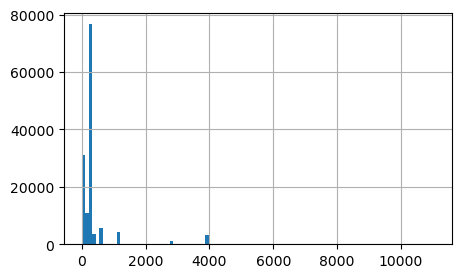

In [7]:
vis_data.balance_due[vis_data.balance_due > 0].hist(bins = 100, figsize = (5, 3))

Одним из способов сделать данные более "нормальными" является логарифмирование.  
При этом не должно быть значений, равных 0, иначе метод `np.log` выдаст $-\infty$.

<AxesSubplot:>

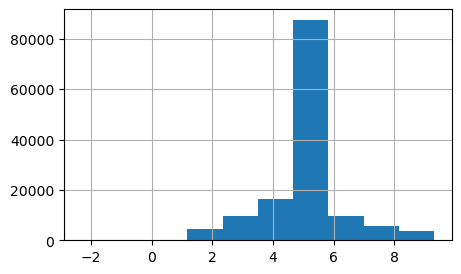

In [8]:
np.log(vis_data.balance_due[vis_data.balance_due > 0]).hist(figsize = (5, 3))

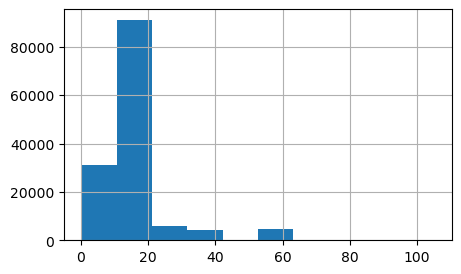

In [9]:
# Другим способом является возведение в квадратный корень 
np.sqrt(vis_data.balance_due[vis_data.balance_due > 0]).hist(figsize = (5, 3));

Выше мы явно отсекли значения в данных, равные `0`. Если значения все-таки начинаются с `0`, перед логарифмированием можно прибавить `1` к данным. Логарифм от `1` превратится в `0`.

<AxesSubplot:>

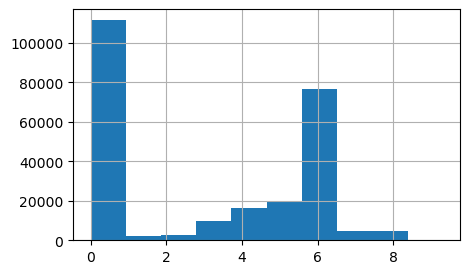

In [10]:
np.log(vis_data.balance_due[vis_data.balance_due >= 0] + 1).hist(figsize = (5, 3))

#### Correlation plot

Некоторые признаки сильно скоррелированы друг с другом. Это свидетельствует о линейной зависимости в данных. Если зависимость большая - часть наиболее скоррелированных признаков (не все) следует убрать из выборки, т.к. они несут избыточную информацию. При этом, отсутствие корреляции не означает отсутствие зависимости - между признаками в таком случае может быть сложная нелинейная зависимость. 

In [62]:
corr = vis_data.drop(['violation_zip_code', 'payment_amount', 'clean_up_cost', 'violation_street_number'], axis = 1). \
                dropna(axis = 1).corr()
cmap = sns.diverging_palette(5, 250, as_cmap = True)

def magnify():
    return [dict(selector = "th", props = [("font-size", "7pt")]),
            dict(selector = "td", props = [('padding', "0em 0em")]),
            dict(selector = "th:hover", props = [("font-size", "12pt")]),
            dict(selector = "tr:hover td:hover", props = [('max-width', '200px'), ('font-size', '12pt')])]

display(corr)
corr.style.background_gradient(cmap, axis = 1) \
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'}) \
    .set_caption("Hover to magify") \
    .set_precision(2) \
    .set_table_styles(magnify())

,ticket_id,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,balance_due
ticket_id,1.000000,-0.038099,-0.038099,-0.005715,-0.019900,-0.012859,0.003718
admin_fee,-0.038099,1.000000,1.000000,0.286289,0.027442,0.322319,0.275884
state_fee,-0.038099,1.000000,1.000000,0.286289,0.027442,0.322319,0.275884
late_fee,-0.005715,0.286289,0.286289,1.000000,-0.013891,0.989371,0.948404
discount_amount,-0.019900,0.027442,0.027442,-0.013891,1.000000,0.040895,-0.018124
judgment_amount,-0.012859,0.322319,0.322319,0.989371,0.040895,1.000000,0.941940
balance_due,0.003718,0.275884,0.275884,0.948404,-0.018124,0.941940,1.000000


C:\Users\user\AppData\Local\Temp\ipykernel_15096\2485201280.py:12: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap, axis = 1) \


,ticket_id,admin_fee,state_fee,late_fee,discount_amount,judgment_amount,balance_due
ticket_id,1.00,-0.04,-0.04,-0.01,-0.02,-0.01,0.00
admin_fee,-0.04,1.00,1.00,0.29,0.03,0.32,0.28
state_fee,-0.04,1.00,1.00,0.29,0.03,0.32,0.28
late_fee,-0.01,0.29,0.29,1.00,-0.01,0.99,0.95
discount_amount,-0.02,0.03,0.03,-0.01,1.00,0.04,-0.02
judgment_amount,-0.01,0.32,0.32,0.99,0.04,1.00,0.94
balance_due,0.00,0.28,0.28,0.95,-0.02,0.94,1.00


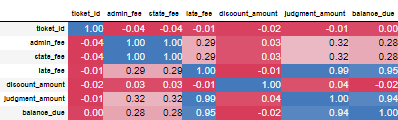

## 6. Создание новых признаков  
- ручное создание признаков,   
- полиномиальные признаки,   
- dummy-переменные,   
- работа с датой/временем.

Создание новых признаков (Feature Engineering) - трудоемкий процесс, который позволяет значительно повысить точность алгоритма при правильном использовании методов. Значительное повышение точности обычно происходит после того, как Data Science разработчик погружается в предметную область задачи, поскольку это позволяет создавать новые признаки осмысленно. Существуют также автоматические / полуавтоматич. методы создания новых признаков. Для исследования темы создания новых признаков воспользуемся датасетом `vis_data` и дополним его новой информацией.

In [4]:
# vis_data = pd.read_csv("train.csv", 
#                        encoding = 'ISO-8859-1', 
#                        low_memory = False)
# display(vis_data.head(3))

vis_data = vis_data.drop(['violation_zip_code', 'clean_up_cost'], axis = 1)
latlons = pd.read_csv("latlons.csv")
vis_data = pd.concat([vis_data, latlons], axis = 1)
display(vis_data.head(3))

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,mailing_address_str_number,mailing_address_str_name,city,state,...,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,3.0,S. WICKER,CHICAGO,IL,...,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,2959.0,Martin Luther King,Detroit,MI,...,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0,"14512 sussex, Detroit MI",42.394657,-83.194265
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,23658.0,P.O. BOX,DETROIT,MI,...,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN,"3456 garland, Detroit MI",42.373779,-82.986228


### Ручное создание признаков

In [5]:
print(f'Столбцы датасета: \n{vis_data.columns}')
print(f'\nУникальные значения признака "compliance": {vis_data.compliance.unique()}')

Столбцы датасета: 
Index(['ticket_id', 'agency_name', 'inspector_name', 'violator_name',
       'violation_street_number', 'violation_street_name',
       'mailing_address_str_number', 'mailing_address_str_name', 'city',
       'state', 'zip_code', 'non_us_str_code', 'country', 'ticket_issued_date',
       'hearing_date', 'violation_code', 'violation_description',
       'disposition', 'fine_amount', 'admin_fee', 'state_fee', 'late_fee',
       'discount_amount', 'judgment_amount', 'payment_amount', 'balance_due',
       'payment_date', 'payment_status', 'collection_status',
       'grafitti_status', 'compliance_detail', 'compliance', 'address', 'lat',
       'lon'],
      dtype='object')

Уникальные значения признака "compliance": [ 0.  1. nan]


Судя по названию переменных, это данные о нарушителях, которые должны оплатить штраф за какое-то правонарушение.  
- В датасете есть переменная *compliance*, которая принимает значения `0`, `1` и `None`. Так как описания нет, мы можем предположить, что 0 - нарушитель заплатил штраф, 1 - не заплатил. Что в данном контексте означает None сказать трудно, возможно, это пропуски, которые следует просто удалить.  
- Кроме изначальных признаков также имеется широта и долгота. Также, есть признак `city`.  

Что можно сделать с таким набором признаков?  Можно, например, посмотреть расстояние от точки правонарушения до центра города, в котором произошло нарушение. Для начала посмотрим, какие города представлены в выборке:

In [6]:
print(f'Всего уникальных городов: {vis_data.city.nunique()}')
vis_data.city.value_counts()[:10]

Всего уникальных городов: 5184


DETROIT             136936
SOUTHFIELD           13436
Detroit              10496
detroit               4183
DEARBORN              3637
FARMINGTON HILLS      2329
OAK PARK              2216
WARREN                2000
DET                   1657
W. BLOOMFIELD         1635
Name: city, dtype: int64

Видно, что подавляющую часть значений составляет `DETROIT`. Ниже также видны `Detroit` и `detroit`.  
Название города с самым большим количеством нарушений записано по-разному. Возможно, некоторые другие города тоже записаны в разном регистре. Необходимо это исправить.

In [7]:
# Приведем названия городов к одному регистру
# vis_data.city = vis_data.city.str.lower()
vis_data.city = vis_data.city.apply(lambda x: x.lower())
vis_data.city.value_counts()[:10]

detroit             151621
southfield           14760
dearborn              4017
farmington hills      2508
oak park              2432
warren                2150
det                   1928
livonia               1798
w. bloomfield         1795
redford               1718
Name: city, dtype: int64

Теперь данные более явно демонстрируют, что большинство преступлений (из представленных в выборке) совершается в Детройте. Также в данных есть значение det, которое, скорее всего, тоже означает Детройт и это значение также можно скорректировать. 
Возможно, информативным признаком будет расстояние от места правонарушения до центра Детройта.  

Найдем для каждого нарушения (для которого есть широта и долгота), его расстояние до центра Детройта со следующими координатами:
 - широта: 42.331429
 - долгота: -83.045753

In [8]:
def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2) ** 2
    c = 2 * asin(sqrt(a))
    earth_radius = 6371 
    return c * earth_radius

vis_data['distance'] = vis_data.apply(lambda row: haversine(lon1 = -83.045753, 
                                                            lat1 = 42.331429,
                                                            lon2 = row['lon'], 
                                                            lat2 = row['lat']), 
                                                            axis = 1)

count    121762.000000
mean         11.553138
std           4.892769
min           0.035651
25%           8.501422
50%          11.696956
75%          14.261028
max         557.825576
Name: distance, dtype: float64

<AxesSubplot:>

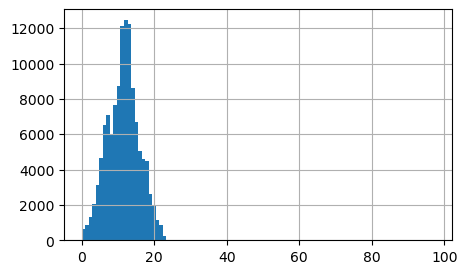

In [9]:
display(vis_data.distance.describe())
vis_data['distance'][vis_data['distance'] < 100].hist(bins = 100, figsize = (5, 3))

### Полиномиальные признаки  
Рассмотрим более механические и менее интеллектуальные способы создания признаков.  
Класс `PolynomialFeatures` из библиотеки `sklearn` принимает на вход набор признаков и на выходе отдает полиномиальные признаки, сгенерированные на основе входных и со степенью меньше либо равной указанной. 

In [21]:
pf = PolynomialFeatures(2)  # [1, a, b, a^2, ab, b^2]

poly_features = pf.fit_transform(vis_data[['balance_due', 'payment_amount']])
display(poly_features[:5])
print(poly_features.shape)

array([[1.0000e+00, 3.0500e+02, 0.0000e+00, 9.3025e+04, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 7.5000e+01, 7.8000e+02, 5.6250e+03, 5.8500e+04,
        6.0840e+05],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

(250306, 6)


### Dummy-переменные

Преобразуем признак `state` в dummy-переменные и посмотрим его размер `shape`:

In [13]:
print(f'Кол-во уникальных значений: {vis_data.state.nunique()} \n{vis_data.state.value_counts()[:7]}')

display(pd.get_dummies(vis_data.state).head(3))
print(pd.get_dummies(vis_data.state).shape)  # drop_first = False \ True

Кол-во уникальных значений: 59 
MI    228601
CA      5020
TX      2420
FL      2237
IL      1310
SC      1304
OH       967
Name: state, dtype: int64


,AK,AL,AR,AZ,BC,BL,CA,CO,CT,DC,...,TX,UK,UT,VA,VI,VT,WA,WI,WV,WY
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


(250306, 59)


Теперь преобразуем признак `city` в dummy-переменные. Для этого сначала проведем небольшую предобработку, чтобы сократить количество уникальных значений в этом признаке. Найдем города, которые описывают большинство `90%` примеров:

In [9]:
# top_cities_cnt = int(vis_data.city.value_counts().quantile(0.9))
top_cities_cnt = int(np.percentile(vis_data.city.value_counts(), 90))
print(top_cities_cnt)

# Оставим только те города, которые описывают 90% примеров, остальные города назовем other
# cities_to_throw_away = vis_data.city.value_counts().index[top_cities_cnt:]
all_cities = vis_data.city.value_counts().index
top_cities = vis_data.city.value_counts().index[:top_cities_cnt]
cities_to_throw_away = list(set(all_cities) - set(top_cities))

vis_data.loc[vis_data['city'].isin(cities_to_throw_away), 'city'] = 'other'
# vis_data.city = vis_data.city.apply(lambda x: x if x in top_cities else 'other')
display(vis_data.city.value_counts())

# Количество уникальных значений в признаке `city` сократилось до 15
print(len(vis_data.city.value_counts()))

# Создадим dummy-признаки для переменной city
pd.get_dummies(vis_data.city, drop_first = True).head()

14


detroit             151621
other                60619
southfield           14760
dearborn              4017
farmington hills      2508
oak park              2432
warren                2150
det                   1928
livonia               1798
w. bloomfield         1795
redford               1718
troy                  1626
west bloomfield       1230
canton                1133
eastpointe             971
Name: city, dtype: int64

15


,dearborn,det,detroit,eastpointe,farmington hills,livonia,oak park,other,redford,southfield,troy,w. bloomfield,warren,west bloomfield
0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### Работа с датой / временем

In [10]:
# Уберем пропуски и преобразуем признак payment_date в специальный формат для работы со временем datetime
datetime_vals = pd.to_datetime(vis_data.payment_date.dropna())
display(datetime_vals.head())

# Теперь к этим значениям можно обращаться для определения дня, месяца или года. Отсчет начинается с понедельника и с нуля
display(f'Month: {datetime_vals[1].month}')
display(f'Weekday: {datetime_vals[1].weekday()}')   # datetime_vals.iloc[0].month

# datetime_vals.dt.weekday
# datetime_vals.dt.dayofweek

1    2005-06-02
11   2005-03-17
15   2005-02-11
18   2005-03-18
19   2005-03-18
Name: payment_date, dtype: datetime64[ns]

'Month: 6'

'Weekday: 3'

В текущем наборе данных можно использовать такой признак как будний день / выходной, чтобы определить, когда чаще совершают правонарушения

In [11]:
# Создадим новый признак is_weekend, для этого воспользуемся селектором (аксессором) dt
vis_data['wd'] = pd.to_datetime(vis_data.ticket_issued_date).dt.weekday
vis_data['is_weekend'] = vis_data['wd'] > 4

display(vis_data[['wd', 'is_weekend']].head(5))
print('Процентное соотношение происшествий в зависимости от дня недели:')
vis_data.wd.value_counts(normalize = True).apply(lambda x: round(x, 2))

,wd,is_weekend
0,1,False
1,4,False
2,0,False
3,0,False
4,0,False


Процентное соотношение происшествий в зависимости от дня недели:


1    0.23
2    0.22
3    0.20
0    0.18
4    0.16
5    0.00
6    0.00
Name: wd, dtype: float64

## 7. Поиск выбросов (outliers)  
- поиск и удаление по порогу,  
- поиск по отклонению (z-score),   
- IQR,   
- поиск по распределению,   
- DBSCAN.

### Поиск и удаление по порогу

В столбце fine_amount нет значений меньше нуля.
Максимальный размер штрафа: 10000.0
Сколько раз в данных встречается максимальный штраф: 357 
Как часто в данных встречается максимальный штраф: 0.001


C:\Users\user\AppData\Local\Temp\ipykernel_15096\2291410650.py:3: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print(f'В столбце fine_amount {["есть значения", "нет значений"][np.sum(vis_data.fine_amount < 0) == 0]} меньше нуля.')


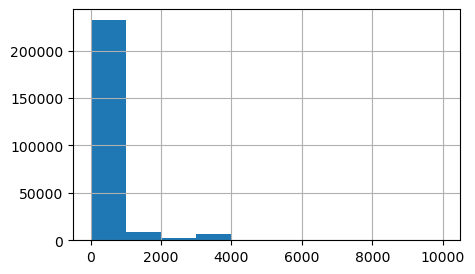

In [152]:
# Проверим, нет ли в выборке значений штрафов, меньше нуля
# vis_data.loc[vis_data.fine_amount < 0]
print(f'В столбце fine_amount {["есть значения", "нет значений"][np.sum(vis_data.fine_amount < 0) == 0]} меньше нуля.')

# Посчитаем максимальный размер штрафа
max_fine = np.max(vis_data.fine_amount)   # vis_data.fine_amount.max()
print(f'Максимальный размер штрафа: {max_fine}') 

# Посмотрим сколько раз и как часто максимальный штраф встречается в данных
# max_fine_count = vis_data[vis_data.fine_amount.isin([max_fine])].ticket_id.count()
# max_fine_count = (vis_data.fine_amount == max_fine).value_counts()[1]
# max_fine_count = np.unique(vis_data.fine_amount == max_fine, return_counts = True)[1][1]
max_fine_count = np.sum(vis_data.fine_amount == max_fine)
print(f'Сколько раз в данных встречается максимальный штраф: {max_fine_count} \nКак часто в данных встречается максимальный штраф: {round(max_fine_count / vis_data.shape[0], 3)}')

vis_data.fine_amount.hist(figsize = (5, 3));

In [14]:
# Значительное количество данных сосредоточено около нуля. Посмотрим, сколько значений штрафов в выборке равно 0
# vis_data[vis_data.fine_amount == 0 ].ticket_id.count()
# (vis_data.fine_amount == 0).sum()
vis_data.loc[vis_data.fine_amount == 0].shape[0]

195

Возможно, те значения, где размер штрафа равен 0, являются выбросами, если инспектор забыл добавить размер штрафа или ошибся при вводе.  
В таком случае эти значения следует убрать из выборки. В то же время, сложно однозначно сделать такое решение, не зная всей информации о данных.

<AxesSubplot:>

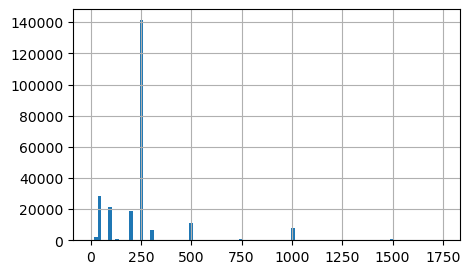

In [15]:
# Посмотрим на данные поближе
vis_data.fine_amount[vis_data.fine_amount < 2000].hist(bins = 100, figsize = (5, 3))

Можно категоризировать данные, заменив все значения больше 2000 на переменную `>2000`, сделав все остальные значения категориальными.

### Поиск по отклонению (z-score)
[Источник](http://colingorrie.github.io/outlier-detection.html)

Этот метод основан на поиске значения, на которое отклоняется данная точка от среднего. В таком случае используют **z-score**, то есть, расстояние (измеряемое в количестве стандартных отклонений) от среднего значения точек.  

<AxesSubplot:>

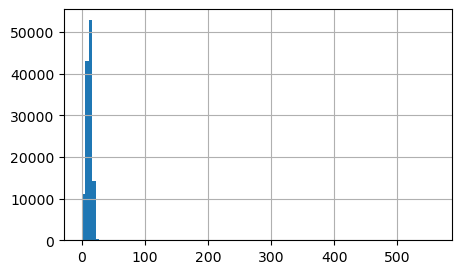

In [164]:
import warnings

# Посмотрим на распределение данных для признака `distance`
vis_data.distance.hist(bins = 100, figsize = (5, 3))

count    121762.000000
mean         11.553138
std           4.892769
min           0.035651
25%           8.501422
50%          11.696956
75%          14.261028
max         557.825576
Name: distance, dtype: float64

<AxesSubplot:>

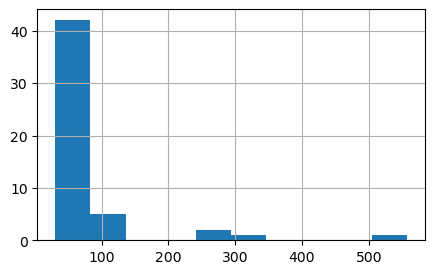

In [38]:
# Попытаемся "на глаз" определить порог, после которого мы считаем значения выбросами 
# Применим этот порог и посмотрим на количество "выбросов"
display(vis_data.distance.describe())
vis_data.distance[vis_data.distance > 30].hist(figsize = (5, 3))

In [18]:
# Функция для определения выбрасов при помощи z_score
def outliers_z_score(ys, threshold = 3):
    mean_y = np.mean(ys)
    std_y = np.std(ys)
    z_scores =  [(y - mean_y) / std_y for y in ys]
    return np.where(np.abs(z_scores) > threshold)[0]

In [41]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    outl = outliers_z_score(vis_data.distance)
    
print(f'Количество обозначенных выбросов: {len(outl)}')
print(outl[:15])

Количество обозначенных выбросов: 55
[ 1007  2879  4170  6726  7861  8831 12314 16177 16820 17178 17976 20861
 21610 22131 22516]


Значение по умолчанию для функции поиска выбросов равно `3`. Это означает, что мы считаем выбросами все, что находится на расстоянии больше 3-x стандартных отклонений от среднего. Если мы подвинем этот параметр в большую или меньшую сторону, мы найдем меньше или больше выбросов.

count     55.000000
mean      75.111437
std       88.958073
min       26.306244
25%       35.297039
50%       51.182274
75%       72.369366
max      557.825576
Name: distance, dtype: float64

<AxesSubplot:>

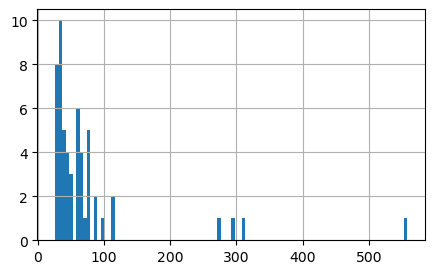

In [27]:
display(vis_data.distance.loc[outl].describe())
vis_data.distance.loc[outl].hist(figsize = (5, 3), bins = 100)

### IQR (interquartile range) -  межквартильное расстояние

Используем квартили для нахождения выбросов. Посмотрим на `boxplot` для признака `distance`.

<AxesSubplot:>

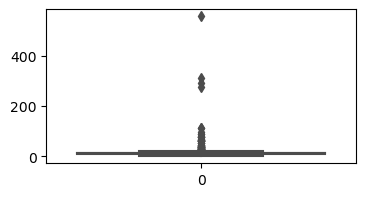

In [56]:
# Посмотрим на `boxplot` для признака `distance`
# vis_data[['distance']].boxplot(figsize = (5, 3), color = 'blue')

plt.figure(figsize = (4, 2))
sns.boxplot(vis_data.distance, color = 'yellow')

<AxesSubplot:xlabel='distance'>

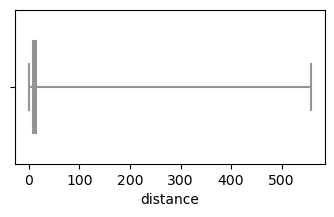

In [54]:
plt.figure(figsize = (4, 2))
sns.boxplot(vis_data, x = "distance", whis = [0, 100], width = .6, palette = "vlag")

<AxesSubplot:xlabel='distance'>

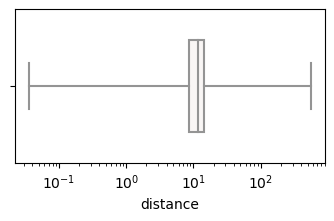

In [55]:
f, ax = plt.subplots(figsize = (4, 2))
ax.set_xscale("log")
sns.boxplot(vis_data, x = "distance", whis = [0, 100], width = .6, palette = "vlag")

Метод межквартильного расстояния выделяет как выбросы все значения, находящиеся за пределами "коробки".  
Посмотрим, сколько выбросов он найдет. Данный метод чувствителен к пропускам, поэтому избавимся от них.

In [170]:
# vis_data.distance.describe()

def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])   # vis_data.distance.quantile([0.25, 0.75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

outliers = outliers_iqr(vis_data.distance.dropna())
print(f'Количество обозначенных выбросов: {len(outliers)}')
outliers[:15]

Количество обозначенных выбросов: 134


array([ 1007,  1674,  2280,  2458,  2516,  2879,  3024,  4169,  4336,
        5731,  6725,  7860,  8830, 10033, 11646], dtype=int64)

count    134.000000
mean      44.579406
std       62.186659
min       22.901562
25%       23.066997
50%       23.576884
75%       39.135844
max      557.825576
Name: distance, dtype: float64

<AxesSubplot:>

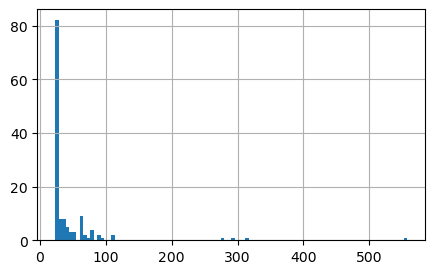

In [65]:
# Посмотрим, какие значения были определены как выбросы
# outliers_list = outliers.tolist()
display(vis_data.distance.dropna().iloc[outliers].describe())
vis_data.distance.dropna().iloc[outliers].hist(bins = 100, figsize = (5, 3))

### Поиск по распределению

Еще один способ найти выбросы - построить нормальное распределение поверх данных и посчитать вероятность нахождения в данном распределении для каждого значения. Самые невероятные значения будем считать выбросами.

In [78]:
from scipy.stats import norm

def estimate_gaussian(dataset):
    mu = np.mean(dataset, axis = 0)
    sigma = np.cov(dataset.T)
    return mu, sigma
    
def get_gaussian(mu, sigma):
    distribution = norm(mu, sigma)
    return distribution

def get_probs(distribution, dataset):
    return distribution.pdf(dataset)

In [173]:
mu, sigma = estimate_gaussian(vis_data.distance.dropna())
distribution = get_gaussian(mu, sigma)
probabilities = get_probs(distribution, vis_data.distance.dropna())

In [174]:
round(round(pd.Series(probabilities),3).value_counts(normalize=True),4).reset_index().sort_values(by='index', ascending=False)

,index,0
0,0.017,0.5608
1,0.016,0.4051
2,0.015,0.0336
4,0.014,0.0001
13,0.013,0.0000
10,0.012,0.0000
7,0.011,0.0000
6,0.010,0.0000
8,0.009,0.0000
14,0.008,0.0000


Мы построили нормальное распределение на предоставленных данных и посчитали вероятность появления данной точки при данном распределении для каждого значения. Теперь выберем разумное значение вероятности, ниже которой будем считать точку выбросом и посмотрим количество выбросов. Например, значение `0.014`

Количество выявленных выбросов: 58

Статистика по данным, определенным как выбросы:


count     58.000000
mean      72.566223
std       87.280500
min       25.888811
25%       34.464382
50%       44.808542
75%       68.856396
max      557.825576
Name: distance, dtype: float64

<AxesSubplot:>

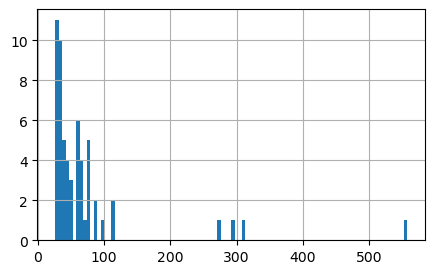

In [175]:
# Выберем значение вероятности (0.014), ниже которого будем считать точку выбросом и посчитаем количество выбросов
o_1 = np.where(probabilities < 0.014)[0]
print(f'Количество выявленных выбросов: {len(o_1)}')

print('\nСтатистика по данным, определенным как выбросы:')
display(vis_data.distance.dropna().iloc[np.where(probabilities <0.014)[0]].describe())

# Построим гистограмму распрделения выбросов
vis_data.distance.dropna().iloc[np.where(probabilities <0.014)[0]].hist(bins = 100, figsize = (5, 3))

### DBSCAN

Алгоритм кластеризации DBSCAN определяет группы (кластеры) объектов. Его особенностью является то, что кроме самих кластеров он хорошо находит отдельно стоящие элементы, "шум". Применим его для нахождения выбросов. 

In [176]:
display(vis_data.shape)

# DBSCAN работает очень медленно, поэтому возьмем не все данные
normalized_distance = np.random.choice(vis_data.distance.dropna().values, 50000).reshape(-1, 1)
dbscan_model = DBSCAN(eps = 0.5, min_samples = 10).fit(normalized_distance)

# Проверим количество выбросов
# pd.Series(dbscan_model.labels_).value_counts()[-1]
print(f"Количество выбросов, найденных с помощью DBSCAN: {len(np.where(dbscan_model.labels_ == -1)[0])}")

(250306, 38)

Количество выбросов, найденных с помощью DBSCAN: 23


#### Сложности с выбросами

Несмотря на то, что выбросы "портят" общую картину и заставляют стат. показатели в данных (например, среднее) выглядеть неправильно, иногда они очень важны:

 - В задаче поиска аномалий (**Anomaly Detection**) выбросы являются зависимыми переменными, которые необходимо выявить, а не значениями, которые нужно выбросить.
 - Нет однозначного способа понять, что перед нами выброс. Разные методы возвращают разные точки в качестве выбросов и эти точки пересекаются лишь частично. Кроме того, разные параметры дают разные результаты и эти параметры необходимо подбирать. Из-за этого найденные выбросы могут быть крайне субъективным результатом.

## 8. Работа с датами

Многие выгрузки из систем и баз данных имеют свой служебный формат. Формат времени из разных систем может отличаться, например:

2018-11-09 15:45:21;  
11/09/2018 3:45:20 PM;  
2018-11-09T15:45:21.2984.  

Для всех этих случаев необходимо задавать формат распознавания дат. Для этого в Python введены обозначения, которые помогут системе правильно распознать практически любой формат даты и времени.    
- <a href="https://docs.python.org/3/library/datetime.html ">официальная документация</a>  

Например, код для распознавания в Python даты 2019-03-01 (1 марта 2019) будет иметь следующий вид: '%Y-%m-%d'.  
Дата и время 2019-04-01T06:30:00 будет иметь вид: %Y-%m-%dT%H:%M:%S

#### Формат unixtime
Популярным форматом записи даты и времени является unixtime (также POSIX-время). Это количество секунд, прошедших с полуночи 1 января 1970 года по часовой зоне UTC (Coordinated Universal Time - Всемирное Координированное Время). Преимущество данного формата в его простоте: обычно это целое число. Также им удобно считать разницу между двумя датами: это будет разница двух чисел в секундах.

Переводить дату в unixtime и обратно можно с помощью кода на Python или специальных онлайн-сервисов, например, <a href="http://www.onlineconversion.com/unix_time.htm">onlineconversion</a>.

### ЗАДАНИЕ 1.  
### Расшифровать предложенные значения даты и времени, записанные в различных форматах

In [90]:
from datetime import datetime, timedelta

1) 12.23.2018 (23 декабря 2018 года)  
Ответ: %m.%d.%Y  

2) 01.13.2019Z15:39:01 (13 января 2019 года, 15 часов 39 минут 1 секунда)  
Ответ: %m.%d.%YZ%H:%M:%S 

3) 23:45 (23 часа 45 минут)  
Ответ: %H:%M  

4) 19.04.2019 08:00 (19 апреля 2019 года, 8 утра)  
Ответ: %d.%m.%Y %H:%M  

5) 01-04-2019, mon, 06:30 (понедельник 1 апреля 2019 года, 6 часов 30 минут)  
Ответ: %d-%m-%Y, %a, %H:%M  

6) 01-01-2019 Sunday (воскресенье 1 января 2019 года)  
Ответ: %d-%m-%Y %A  

7) 1 May 2019 23:59 (1 мая 2019 года, 23 часа 59 минут)  
Ответ: %d %B %Y %H:%M  

8) 14.06.2019 08:00 AM (14 июня 2019 года, 8 утра) будьте внимательны к формату часа  
Ответ: %d.%m.%Y %I:%M %p  

9) 10:40 AM (10 часов 40 минут утра)  
Ответ: %I:%M %p  

10) 15:23  (15 часов 23 минуты)  
Ответ: %H:%M  

11) Mar 08, 2019 (8 марта 2019 года)  
Ответ: %b %d, %Y  

12) Переведите дату 1 января 2019 года (полночь по UTC) в формат unixtime  
Ответ: 1546300800  

13) Аналогично предыдущему заданию переведите 31 января 2019 года (по UTC) в формат unixtime. И посчитайте разницу в секундах между 1 и 31 января 2019 года  
Ответ: 2592000  

14) Дана дата: dt = datetime(2019, 4, 1, 18, 59, 44). Выведите её в виде строки формата %Y-%m-%d  
Ответ: 2019-04-01

**15. Дана строка с датой** date_string = '2019-07-07T18:59:33', **преобразуйте ее в строку с форматом** %d.%m.%Y.  
**Результат запишите в переменную date_format.**

In [207]:
date_string = '2019-07-07T18:59:33'
dt = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S') 
date_format = dt.strftime('%d.%m.%Y')
print(date_format)
print(type(date_format))

07.07.2019
<class 'str'>


**16. У вас есть список запуска отчёта по расписанию:**  
dt_list = ['2019-07-07T18:59:06', '2019-07-07T19:00:02', '2019-07-07T19:01:04']

**Переведите эти значения из строк в формат datetime и запишите результат в переменную datetime_list. В переменной datetime_list должен быть список элементов вида datetime(2019, 7, 7, 18, 59, 6).**

In [191]:
# List comprehension
datetime_list = [datetime.strptime(elem, '%Y-%m-%dT%H:%M:%S') for elem in ['2019-07-07T18:59:06', '2019-07-07T19:00:02', '2019-07-07T19:01:04']]
print(datetime_list)

# Ordinary cycle 
dt_list = ['2019-07-07T18:59:06', '2019-07-07T19:00:02', '2019-07-07T19:01:04']
datetime_list = []
for elem in dt_list:                                          
    new_elem = datetime.strptime(elem, '%Y-%m-%dT%H:%M:%S')   
    datetime_list.append(new_elem)
print(datetime_list)

[datetime.datetime(2019, 7, 7, 18, 59, 6), datetime.datetime(2019, 7, 7, 19, 0, 2), datetime.datetime(2019, 7, 7, 19, 1, 4)]
[datetime.datetime(2019, 7, 7, 18, 59, 6), datetime.datetime(2019, 7, 7, 19, 0, 2), datetime.datetime(2019, 7, 7, 19, 1, 4)]


**17. В прошлом задании у вас получился список datetime_list с элементами типа datetime.**

**Наш отчёт запускался каждую минуту в 18:59:00, 19:00:00 и 19:01:00. Посчитайте для каждого элемента количество секунд, которое работал скрипт. Результат запишите в список report_seconds (каждый элемент, соответственно, целое число).**

In [2]:
datetime_list = [datetime(2019, 7, 7, 18, 59, 6),
                 datetime(2019, 7, 7, 19, 0, 2),
                 datetime(2019, 7, 7, 19, 1, 4)]

report_seconds = [i.second for i in datetime_list]
print(report_seconds)

# report_seconds = list(map(int, [datetime.strftime(date, '%S') for date in datetime_list]))

# report_seconds = []
# for date in datetime_list:
#     report_seconds.append(date.second)
# report_seconds

[6, 2, 4]


**18. Посчитайте суммарное время выполнения скрипта в секундах из списка report_seconds прошлого задания.  
Результат запишите в переменную total_time (целое число секунд).**

In [201]:
# total_time = sum([i.second for i in datetime_list])
total_time = np.sum(list(map(int, [datetime.strftime(date, '%S') for date in datetime_list])))
print(total_time)

12


#### 19. У вас есть дата начала выгрузки start_date = '2019-01-01'. Прибавьте к этой дате день.

In [204]:
# Параметры timedelta: microseconds, milliseconds, seconds, minutes, hours, days, weeks
start_date = '2019-01-01'
new_start_date = datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days = 1)
print(new_start_date)
print(type(new_start_date))
new_start_date

2019-01-02 00:00:00
<class 'datetime.datetime'>


datetime.datetime(2019, 1, 2, 0, 0)

#### 20. Отнимите 7 дней от даты start_date = '2019-01-01'

In [208]:
# datetime.strptime(start_date, '%Y-%m-%d') - timedelta(days =7)
start_date = '2019-01-01'
new_start_date = datetime.strptime(start_date, '%Y-%m-%d') + timedelta(days = -7)
print(new_start_date)
new_start_date

2018-12-25 00:00:00


datetime.datetime(2018, 12, 25, 0, 0)

#### 21. Прибавьте один час к дате start_date = '2019-01-01'.

In [210]:
start_date = '2019-01-01'
new_start_date = datetime.strptime(start_date, '%Y-%m-%d') + timedelta(hours = 1)
print(new_start_date)
new_start_date

2019-01-01 01:00:00


datetime.datetime(2019, 1, 1, 1, 0)

#### 22. Представим, что нам необходимо из огромной таблицы с данными за год выбрать показатели за новогодние праздники с 1 по 7 января (start_date = '2019-01-01'; end_date = '2019-01-07'). Реализуейте алгоритм, который по дате начала и конца выгрузки будет «пробегать» все значения по дням.  


In [241]:
start_date = '2019-01-01'
end_date = '2019-01-07'

# Перевем переменные в формат datetime
start_date_datetime = datetime.strptime(start_date, '%Y-%m-%d') 
end_date_datetime = datetime.strptime(end_date, '%Y-%m-%d')

# Реализуем цикл
current_day = start_date_datetime
while current_day <= end_date_datetime:
    print(current_day)
    current_day += timedelta(days = 1) 

2019-01-01 00:00:00
2019-01-02 00:00:00
2019-01-03 00:00:00
2019-01-04 00:00:00
2019-01-05 00:00:00
2019-01-06 00:00:00
2019-01-07 00:00:00


In [242]:
# Для удобства вывода заменим вывод current_day на более наглядный строковый эквивалент в формате даты
current_day = start_date_datetime

while current_day <= end_date_datetime:
    print(current_day.strftime('%Y-%m-%d'))
    current_day += timedelta(days = 1)

2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07


### ЗАДАНИЕ 2.   
### Ответить на вопросы, применив различные способы трансформации данных
В задании используется датасет с информацией о нарушителях, которые должны оплатить штраф  

In [3]:
# Загрузим датасет и посмотрим на данные
vis_data = pd.read_csv("train.csv", encoding = 'ISO-8859-1', low_memory = False)
vis_data.head(3)

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,...,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,...,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0
1,27586,"Buildings, Safety Engineering & Env Department","Williams, Darrin","Michigan, Covenant House",4311.0,CENTRAL,NaN,2959.0,Martin Luther King,Detroit,...,0.0,855.0,780.0,75.0,2005-06-02 00:00:00,PAID IN FULL,NaN,NaN,compliant by late payment within 1 month,1.0
2,22062,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","SANDERS, DERRON",1449.0,LONGFELLOW,NaN,23658.0,P.O. BOX,DETROIT,...,0.0,0.0,0.0,0.0,NaN,NO PAYMENT APPLIED,NaN,NaN,not responsible by disposition,NaN


#### 1. Найдите признак, обозначающий штат. Замените пропуски значением, которое встречается чаще всего, и запишите получившийся признак в переменную result.

In [217]:
# vis_data.state[pd.isna(vis_data.state)]
# vis_data.state[vis_data.state.isna()]

# Посмотрим количество пропусков
sum_of_nans = vis_data['state'].isna().sum()    # len(vis_data.state[pd.isna(vis_data.state)])
print(f'Количество пропусков до обработки: {sum_of_nans}')

# Найдем наиболее часто встречающееся значение в столбце 'state'
# most_frequent = vis_data.state.describe().loc['top']
most_frequent = vis_data['state'].value_counts(ascending = False).index[0]
print(f'Наиболее часто встречающееся значение в столбце: {most_frequent}')
display(vis_data['state'].value_counts(ascending = False)[:5])

# Заменим пропуски значением, которое встречается чаще всего, и запишем признак в переменную result
result = vis_data['state'].fillna(most_frequent)
sum_of_nans2 = result.isna().sum()
print(f'\nКоличество пропусков после обработки: {sum_of_nans2}')
display(result.value_counts(ascending = False)[:5])

Количество пропусков до обработки: 93
Наиболее часто встречающееся значение в столбце: MI


MI    228601
CA      5020
TX      2420
FL      2237
IL      1310
Name: state, dtype: int64


Количество пропусков после обработки: 0


MI    228694
CA      5020
TX      2420
FL      2237
IL      1310
Name: state, dtype: int64

#### 2. Найдите признак, обозначающий баланс. Нормализуйте его с помощью std-нормализации. В качестве ответа укажите минимальное значение в получившемся нормализованном признаке. Ответ округлите до 5 знаков после запятой.

#### 3. Возьмите корень у положительных значений признака, обозначающего баланс, найдите медианное и среднее значение. В качестве ответа укажите модуль разницы этих значений.

#### 4. Прологарифмируйте положительные значения признака, обозначающего баланс, найдите медианное и среднее значение. В качестве ответа укажите модуль разницы этих значений.

In [20]:
# Задание 2
from sklearn.preprocessing import StandardScaler
balance_due = vis_data['balance_due'].values.reshape(-1, 1)  # 250306, 1
scaler = StandardScaler()
print(f'Минимальное значение в нормализованном признаке "balance_due": {round(scaler.fit_transform(balance_due).min(), 5)}')

# Задание 3
dif_sqrt = np.abs(np.sqrt(vis_data[vis_data['balance_due'] > 0]['balance_due']).median() - np.sqrt(vis_data[vis_data['balance_due'] > 0]['balance_due']).mean())
print(f'Модуль разницы медианного и среднего значения корня признака "balance_due": {round(dif_sqrt, 5)}')

# Задание 4
dif_log = np.abs(np.log(vis_data[vis_data['balance_due'] > 0]['balance_due']).median() - np.log(vis_data[vis_data['balance_due'] > 0]['balance_due']).mean())
print(f'Модуль разницы медианного и среднего значения прологарифмированного признака "balance_due": {round(dif_log, 5)}')

Минимальное значение в нормализованном признаке "balance_due": -13.14733
Модуль разницы медианного и среднего значения корня признака "balance_due": 0.4526
Модуль разницы медианного и среднего значения прологарифмированного признака "balance_due": 0.37389


#### 5. Оставьте только два признака: balance_due и payment_amount (признаки должны следовать именно в указанном порядке). Создайте из полученных признаков полиномиальные признаки степени 3. Посчитайте среднее значение для каждого получившегося признака.  
В качестве ответа укажите индекс признака, который содержит максимальное среднее значение.

In [21]:
new_df = vis_data[['balance_due', 'payment_amount']]
display(new_df.head(3))
print(f'Размер изначального датасета: {new_df.shape}')

# Создание полиномиальных признаков
# pol_features = PolynomialFeatures(3).fit_transform(new_df)
# pd.Series(pol_features.mean(axis = 0)).sort_values(ascending = False)[:1]

pol_features = PolynomialFeatures(3).fit_transform(new_df)
pol_df = pd.DataFrame(pol_features)
display(pol_df.head(3))
print(f'Размер датасета c полиномиальными признаками: {pol_features.shape}')

max_value = pol_df.mean().sort_values(ascending = False)
print(f'Индекс признака, который содержит максимальное среднее значение и само значение: {max_value.index[0], max_value.iloc[0]}')

,balance_due,payment_amount
0,305.0,0.0
1,75.0,780.0
2,0.0,0.0


Размер изначального датасета: (250306, 2)


,0,1,2,3,4,5,6,7,8,9
0,1.0,305.0,0.0,93025.0,0.0,0.0,28372625.0,0.0,0.0,0.0
1,1.0,75.0,780.0,5625.0,58500.0,608400.0,421875.0,4387500.0,45630000.0,474552000.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Размер датасета c полиномиальными признаками: (250306, 10)
Индекс признака, который содержит максимальное среднее значение и само значение: (6, 2042000980.3445694)


In [35]:
# ДРУГОЙ СПОСОБ РЕШЕНИЯ

new_df = vis_data[['balance_due', 'payment_amount']]
display(new_df.head(3))

pol_features = PolynomialFeatures(3).fit_transform(new_df)
display(pol_features.shape)

mean_values_dict = {}
for i in range(pol_features.shape[1]):
    mean_values_dict[i] = round(np.mean(pol_features[:, i]))

print('\nСловарь средних значений признаков:')
display(mean_values_dict)

max_value = sorted(mean_values_dict.items(), key = lambda x: x[1], reverse = True)[0]
print(f'Признак c индексом {max_value[0]} содержит максимальное среднее значение: {max_value[1]}')

,balance_due,payment_amount
0,305.0,0.0
1,75.0,780.0
2,0.0,0.0


(250306, 10)


Словарь средних значений признаков:


{0: 1,
 1: 222,
 2: 49,
 3: 417196,
 4: 667,
 5: 51863,
 6: 2042000980,
 7: 8597853,
 8: -3509170,
 9: 177998080}

Признак c индексом 6 содержит максимальное среднее значение: 2042000980


### Способы получения ключа с максимальным значением в словаре Python

In [229]:
pprint(mean_values_dict)

{0: 1,
 1: 222,
 2: 49,
 3: 417196,
 4: 667,
 5: 51863,
 6: 2042000980,
 7: 8597853,
 8: -3509170,
 9: 177998080}


In [242]:
# 1. Использование operator.itemgetter() 
import operator
x = max(mean_values_dict.items(), key = operator.itemgetter(1))
print(x)     # напечатать пару
print(x[1])  # напечатать ключ 

# 2. Использование dict.get() 
# Функция возвращает ключ с максимальным значением
x_max = max(mean_values_dict, key = mean_values_dict.get)
x_min = min(mean_values_dict, key = mean_values_dict.get)
print(x_max)
print(x_min)

#  Альтернативная версия с использованием лямбда-выражений
x_max = max(mean_values_dict, key = lambda x: mean_values_dict[x])
x_min = min(mean_values_dict, key = lambda x: mean_values_dict[x])
print(x_max)
print(x_min)

(6, 2042000980)
2042000980
6
8
6
8


In [248]:
# 3. Использование обратного словаря
# инвертировать каждую пару ключ / значение словаря. Например, словарь { k1: v1, k2: v2, … , kn: vn} 
# должен быть преобразован в словарь { v1: k1, v2: k2, … , vn: kn}
inv = {v: k for k, v in mean_values_dict.items()}
print(inv)
x = inv[max(inv)]
print(x)

# В качестве альтернативы можно написать:
m = max(mean_values_dict.values())
x = next(k for k, v in mean_values_dict.items() if v == m)  # print(*[k for k, v in mean_values_dict.items() if v == m])
print(x)   

{1: 0, 222: 1, 49: 2, 417196: 3, 667: 4, 51863: 5, 2042000980: 6, 8597853: 7, -3509170: 8, 177998080: 9}
6
6


#### 6. Найдите признак, обозначающий баланс. Уберите пропуски из этого признака и найдите выбросы с помощью межквартильного расстояния. Найдите разницу между максимальным и минимальным среди значений, которые остались после удаления выбросов.

In [16]:
def outliers_iqr(ys):
    '''Функция для выявления выбросов при помощи IQR'''
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1   
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    return np.where((ys > upper_bound) | (ys < lower_bound))[0]

count    250306.000000
mean        222.449058
std         606.394010
min       -7750.000000
25%           0.000000
50%          25.000000
75%         305.000000
max       11030.000000
Name: balance_due, dtype: float64

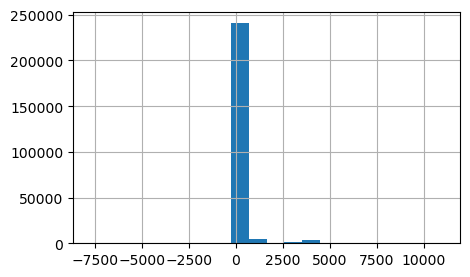

In [260]:
# Посмотрим на распределение признака balance_due
vis_data.balance_due.dropna().hist(bins = 20, figsize = (5, 3))
vis_data.balance_due.describe()

Количество строк до удаления выбросов: 250306
Количество строк после удаления выбросов: 240473
Разница между максимальным и минимальным среди значений, которые остались после удаления выбросов: 1201.3


<AxesSubplot:>

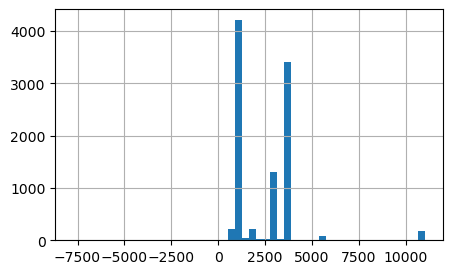

In [261]:
print(f'Количество строк до удаления выбросов: {len(vis_data.balance_due)}')

outliers = outliers_iqr(vis_data['balance_due'].dropna())
vis_data_2 = vis_data.copy()
vis_data_2 = vis_data_2.drop(outliers.tolist())
difference = vis_data_2.balance_due.max() - vis_data_2.balance_due.min()

print(f'Количество строк после удаления выбросов: {len(vis_data_2.balance_due)}')
print(f'Разница между максимальным и минимальным среди значений, которые остались после удаления выбросов: {difference}')

# Посмотрим, какие значения были определены как выбросы
outliers_list = outliers.tolist()
vis_data.balance_due.dropna().iloc[outliers_list].hist(bins = 50, figsize = (5, 3))

<AxesSubplot:>

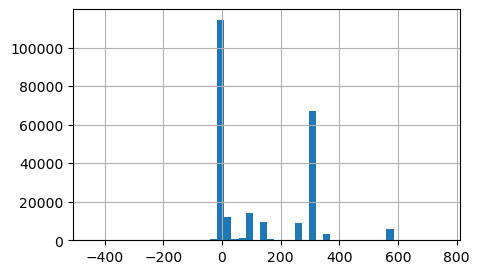

In [262]:
# Посмотрим, какие значения остались после удаления выбросов
vis_data_2.balance_due.hist(bins = 50, figsize = (5, 3))

In [263]:
# ДРУГОЙ ВАРИАНТ РЕШЕНИЯ

def elems_within_boudaries_iqr(ys):
    '''Функция для нахлждения индексов элементов, которые не являются выбросами'''
    quantile_1, quantile_3 = np.percentile(ys, [25,75])  # ys.quantile([0.25, 0.75])
    iqr = quantile_3 - quantile_1
    lower_boundary = quantile_1 - iqr * 1.5
    higher_boundary = quantile_3 + iqr * 1.5
    not_outliers = np.where(~((ys < lower_boundary) | (ys > higher_boundary)))[0]
    return not_outliers


elems = elems_within_boudaries_iqr(vis_data.balance_due.dropna())
max_, min_ = vis_data.balance_due.dropna().iloc[elems].agg(['max', 'min']) 
print(f'Разница между максимальным и минимальным значениями: {max_ - min_}')

Разница между максимальным и минимальным значениями: 1201.3


#### 7. Найдите признак, обозначающий дату, когда был выписан штраф. Найдите, сколько раз штраф был выписан на выходных и запишите это число в качестве ответа.

In [265]:
day_of_week = pd.to_datetime(vis_data['ticket_issued_date'])
print(day_of_week.dt.weekday.value_counts()[[5, 6]].sum())

# len(day_of_week.dt.weekday[day_of_week.dt.weekday.isin([5, 6])])
# day_of_week.dt.weekday[day_of_week.dt.weekday.isin([5, 6])].count()

1620


### ЗАДАНИЕ 3.   
### Ответить на вопросы, применив различные способы трансформации данных
В задании используется датасет с информацией о квартирах в Москве, выставленных на продажу.

#### 1. Загрузите датасет. Избавьтесь от пропусков.  
Просто удалять данные с пропусками довольно грубо. Однако если имеется большое количество объектов, и лишь крайне малая их доля имеет пропущенные значения, то это возможное допущение. Поступим здесь таким образом. Нас будут интересовать только те квартиры, про которые продавцы заполнили все данные.  

**Удалите все строки, где есть хотя бы один пропуск и запишите получившийся датасет в переменную data_2.  
Сколько объектов осталось?**

In [114]:
# Загрузим датасет 
data = pd.read_csv('data_flats_sf.csv', sep = ';')
display(data.head(3))
display(data.shape)
print(f'Размер изначального датасета: {data.shape}\nПосмотрим, в каких колонках есть пропуски и количество пропусков: \n{data.isna().sum()[data.isna().sum() != 0]}')

# Избавимся от пропусков и посмотрим, сколько осталось объектов 
data_2 = data.dropna(axis = 0)
print(f"После удаления пропусков осталось {len(data_2)} объекта.")

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,price_doc
0,1,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,...,0.648488,0.637189,0.947962,0.177975,0.625783,0.628187,14.053047,7.389498,good,5850000
1,2,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,...,0.519311,0.688796,1.072315,0.273345,0.967821,0.471447,6.829889,0.709260,excellent,6000000
2,3,43,29.0,2.0,Tekstil'shhiki,1463.0,4,5580.0,7,0,...,1.486533,1.543049,0.391957,0.158072,3.178751,0.755946,4.273200,3.156423,poor,5700000


(30469, 56)

Размер изначального датасета: (30469, 56)
Посмотрим, в каких колонках есть пропуски и количество пропусков: 
life_sq                       6383
floor                          167
preschool_quota               6688
school_quota                  6685
hospital_beds_raion          14440
metro_min_walk                  25
metro_km_walk                   25
railroad_station_walk_km        25
railroad_station_walk_min       25
dtype: int64
После удаления пропусков осталось 13652 объекта.


#### 2. Предположим, что вы хотите проанализировать состояние цен на квартиры в нескольких  районах : "Лефортово", "Перово", "Басманное" и "Богородское".   Постройте боксплоты для распределения цен по этим районами (должно получиться четыре боксплота - по одному для каждого района).  

На основании полученных диаграмм ответьте на вопросы: 
- В каком районе разброс цен самый большой?  
- В каком районе самая низкая медианная цена?

<AxesSubplot:xlabel='sub_area', ylabel='price_doc'>

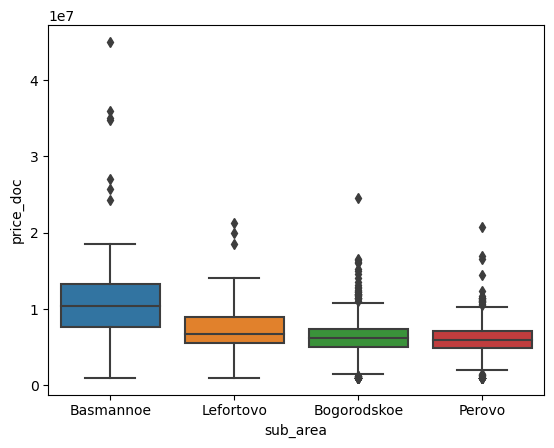

In [546]:
districts = data.sub_area.loc[data.sub_area.isin(['Lefortovo', 'Basmannoe', 'Perovo', 'Bogorodskoe'])]
sns.boxplot(x = districts, y =  data.price_doc)

Cамый большой разброс цен в Басманном рн.  
Самая низкая медианная цена в рн. Перово.

#### 3. В датасете есть признаки, которые содержат текстовые значения : ординальный (уровень экологии) и категориальный (район).  Необходимо перекодировать эти признаки, иначе к ним будет сложно применять математические алгоритмы.   
**Сколько признаков в датасете после перекодировки? Найдите среднее арифметическое для признака "Экология". Округлите до сотых**

In [108]:
data = pd.read_csv('data_flats_sf.csv', sep = ';')
display(data.head(3))
print(f'Размер изначального датасета: {data.shape}\nУникальные значения признака "ecology": {data.ecology.unique()}')
print(f'Количество пропусков в признаке: {data.ecology.isna().sum()}')
display(data.ecology.value_counts())

# Создание словаря и перекодировка ординального признака ecology
ecology_dict = {'no data': 0, 'poor' : 1, 'satisfactory': 2, 'good': 3, 'excellent': 4}
print(f"Словарь для перекодировки признака 'ecology': {ecology_dict}")

# data.ecology.map(ecology_dict)
# data.ecology.apply(lambda x: ecology_dict[x])
data.ecology = data.ecology.replace(to_replace = ecology_dict)
print(f"Уникальные значения признака 'ecology' после перекодировки: {data.ecology.unique()}")
display(data[['ecology']].head(5))

# Создание дамми-переменных и преобразование датасета
sub_area = pd.get_dummies(data.sub_area)
data = pd.concat([sub_area, data.drop('sub_area', axis = 1)], axis = 1)
data.head(3)
print(f'Размер датасета после добавления дамми-переменных: {data.shape}')

# Среднее арифметическое для признака "Экология":
mean_ecology = round(data.ecology.mean(), 2)
print(f'\nСреднее арифметическое для признака "Экология": {mean_ecology}')
data.head(3)

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,price_doc
0,1,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,...,0.648488,0.637189,0.947962,0.177975,0.625783,0.628187,14.053047,7.389498,good,5850000
1,2,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,...,0.519311,0.688796,1.072315,0.273345,0.967821,0.471447,6.829889,0.709260,excellent,6000000
2,3,43,29.0,2.0,Tekstil'shhiki,1463.0,4,5580.0,7,0,...,1.486533,1.543049,0.391957,0.158072,3.178751,0.755946,4.273200,3.156423,poor,5700000


Размер изначального датасета: (30469, 56)
Уникальные значения признака "ecology": ['good' 'excellent' 'poor' 'satisfactory' 'no data']
Количество пропусков в признаке: 0


poor            8017
no data         7656
good            7173
excellent       3938
satisfactory    3685
Name: ecology, dtype: int64

Словарь для перекодировки признака 'ecology': {'no data': 0, 'poor': 1, 'satisfactory': 2, 'good': 3, 'excellent': 4}
Уникальные значения признака 'ecology' после перекодировки: [3 4 1 2 0]


,ecology
0,3
1,4
2,1
3,3
4,4


Размер датасета после добавления дамми-переменных: (30469, 201)

Среднее арифметическое для признака "Экология": 1.73


,Ajeroport,Akademicheskoe,Alekseevskoe,Altuf'evskoe,Arbat,Babushkinskoe,Basmannoe,Begovoe,Beskudnikovskoe,Bibirevo,...,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,price_doc
0,0,0,0,0,0,0,0,0,0,1,...,0.648488,0.637189,0.947962,0.177975,0.625783,0.628187,14.053047,7.389498,3,5850000
1,0,0,0,0,0,0,0,0,0,0,...,0.519311,0.688796,1.072315,0.273345,0.967821,0.471447,6.829889,0.709260,4,6000000
2,0,0,0,0,0,0,0,0,0,0,...,1.486533,1.543049,0.391957,0.158072,3.178751,0.755946,4.273200,3.156423,1,5700000


#### ДРУГОЙ СПОСОБ РЕШЕНИЯ (LabelEncoder, OneHotEncoder)

In [143]:
data = pd.read_csv('data_flats_sf.csv', sep = ';')
display(data.head(3))
print(f'Размер изначального датасета: {data.shape}\n\nПризнак "ecology":\n- Уникальные значения признака: {data.ecology.unique()}')

# Перекодировка признака ecology при помощи класса LabelEncoder
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data.ecology = label_encoder.fit_transform(data['ecology'])
print(f'- Уникальные значения признака после перекодировки LabelEncoder: {data.ecology.unique()}\n- Словарь значений для признака: {dict(enumerate(label_encoder.classes_))}')

# Перекодировка признака sub_area при помощи класса OneHotEncoder  
from sklearn.preprocessing import OneHotEncoder
sub_area = OneHotEncoder(sparse = False).fit_transform(data['sub_area'].values.reshape(-1, 1))
df = np.hstack([data.drop('sub_area', axis = 1), sub_area])
print(f'\nРазмер датасета после OneHot Encoding: {df.shape}')

,id,full_sq,life_sq,floor,sub_area,preschool_quota,preschool_education_centers_raion,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,...,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,theater_km,museum_km,ecology,price_doc
0,1,43,27.0,4.0,Bibirevo,5001.0,5,11065.0,5,0,...,0.648488,0.637189,0.947962,0.177975,0.625783,0.628187,14.053047,7.389498,good,5850000
1,2,34,19.0,3.0,Nagatinskij Zaton,3119.0,5,6237.0,8,0,...,0.519311,0.688796,1.072315,0.273345,0.967821,0.471447,6.829889,0.709260,excellent,6000000
2,3,43,29.0,2.0,Tekstil'shhiki,1463.0,4,5580.0,7,0,...,1.486533,1.543049,0.391957,0.158072,3.178751,0.755946,4.273200,3.156423,poor,5700000


Размер изначального датасета: (30469, 56)

Признак "ecology":
- Уникальные значения признака: ['good' 'excellent' 'poor' 'satisfactory' 'no data']
- Уникальные значения признака после перекодировки LabelEncoder: [1 0 3 4 2]
- Словарь значений для признака: {0: 'excellent', 1: 'good', 2: 'no data', 3: 'poor', 4: 'satisfactory'}

Размер датасета после OneHot Encoding: (30469, 201)
